In [1]:
import os
import pandas as pd
import numpy as np

import cv2
from matplotlib import pyplot as plt

# from sklearn.cluster import KMeans

In [2]:
# Set Path Variables
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data")

In [3]:
# Create Dataset with Images

# Renkler
colors = ['red', 'green', 'blue', 'white', 'gray']
# colors = ['sample']

# Boş bir DataFrame oluştur
df_data = pd.DataFrame(columns=['FilePath', 'FileName', 'Color'])

for color in colors:
    color_path = os.path.join(DATA_PATH, 'train', color)

    # Renk altındaki dosyaları al
    files = os.listdir(color_path)

    # DataFrame'e eklemek için veriyi oluştur
    data = {'FilePath':color_path, 'FileName': files, 'Color': color,}

    # DataFrame'e ekle
    df_data = pd.concat([df_data, pd.DataFrame(data)], ignore_index=True)

file_names = (df_data['FilePath'] + str("\\") + df_data['FileName']).to_list()

In [5]:
df_data

FilePath  \
0   C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
1   C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
2   C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
3   C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
4   C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
..                                                ...   
91  C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
92  C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
93  C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
94  C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   
95  C:\Users\metin\Desktop\YTU\2-BLM5110-ML\Homewo...   

                                             FileName Color  
0   img_122613330v1_2d767811-2514-4724-8fc7-47846e...   red  
1                             IW6220008028034_10.webp   red  
2                         l_20222-w20305z8-gqa_u.webp   red  
3                         l_20222-w2ey82z8-hjy_u.webp   red  
4                         l_20222-w2g372z8-gpu_u.webp   red  
..                                                ...   ...  
91                        l_20232-w3it72z8-v8t_u.webp  gray  
92                        l_20232-w3iy65z8-y4z_u.webp  gray  
93                        l_20232-w3iy66z8-jmd_u.webp  gray  
94                        l_20232-w3j660z8-jnl_u.webp  gray  
95                        l_20232-w3jc36z8-f9q_u.webp  gray  

[96 rows x 3 columns]

In [6]:
# file_names

In [7]:
# 1. Resimleri yükle ve matris olarak elde et
def load_images(file_names):
    images = []

    for file in file_names:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV, renkleri BGR formatında okur, bu nedenle RGB'ye dönüştürüyoruz
        images.append(image)

    return images

In [9]:
images = load_images(file_names)
# images

96

In [10]:
# 2. Renk histogramlarını elde et
def compute_histograms(images):
    histograms = []

    for img in images:
        # BGR renk uzayından RGB'ye çevir
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Her renk bileşeni için histogramları elde et
        hist_r = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
        hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
        hist_b = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])

        histograms.append((hist_r, hist_g, hist_b))

    return histograms

In [11]:
histograms = compute_histograms(images)
# histograms

In [12]:
# 3. Histogramları normalize et
def normalize_histograms(histograms):
    normalized_histograms = []

    for hist_r, hist_g, hist_b in histograms:
        total_pixels = np.sum(hist_r + hist_g + hist_b)

        # Normalize et
        norm_hist_r = hist_r / total_pixels
        norm_hist_g = hist_g / total_pixels
        norm_hist_b = hist_b / total_pixels

        normalized_histograms.append((norm_hist_r, norm_hist_g, norm_hist_b))

    return normalized_histograms

In [18]:
normalized_histograms = normalize_histograms(histograms)
# normalized_histograms

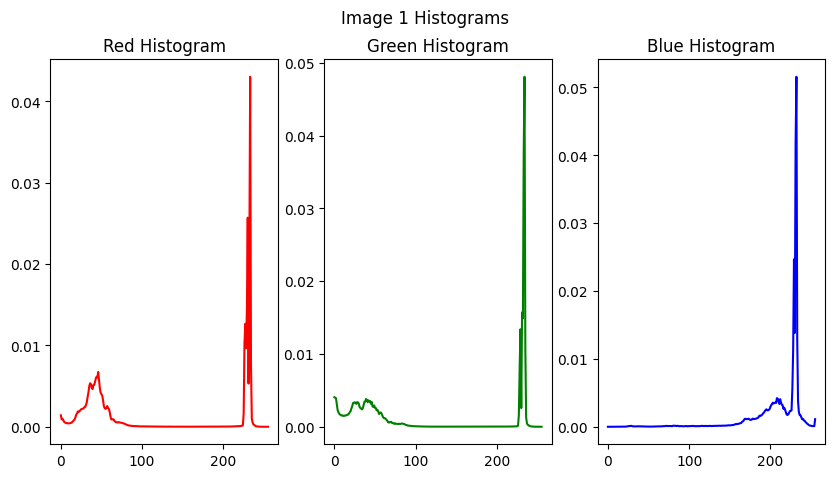

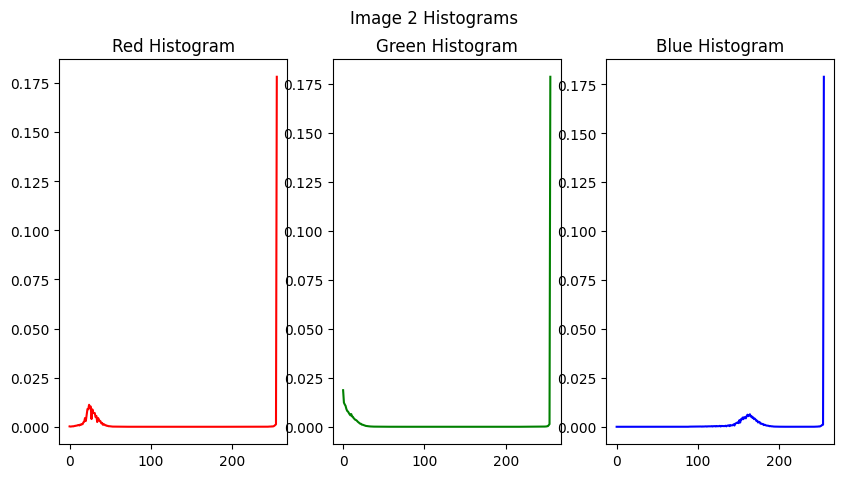

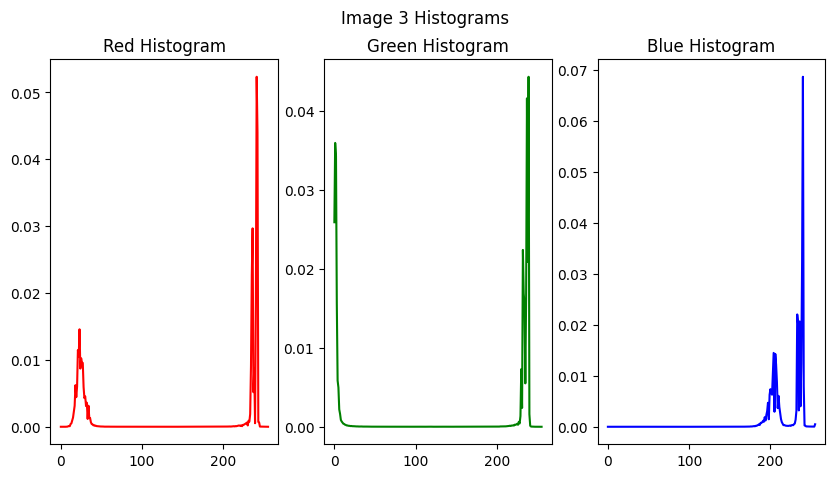

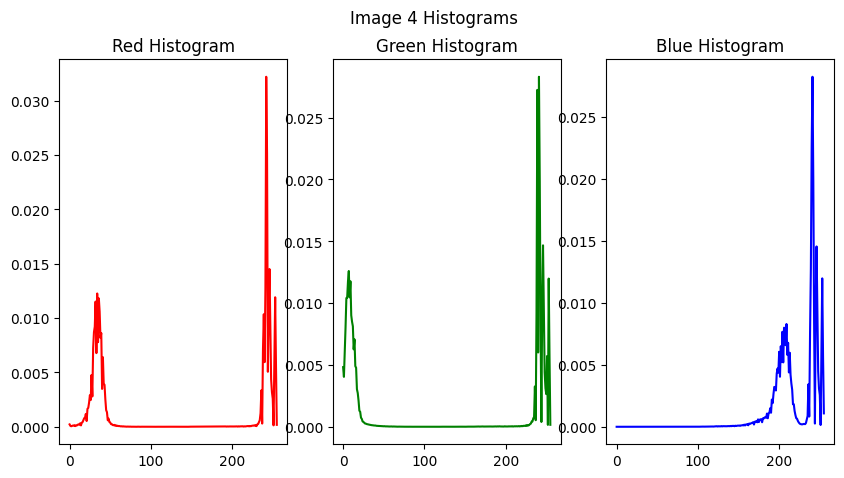

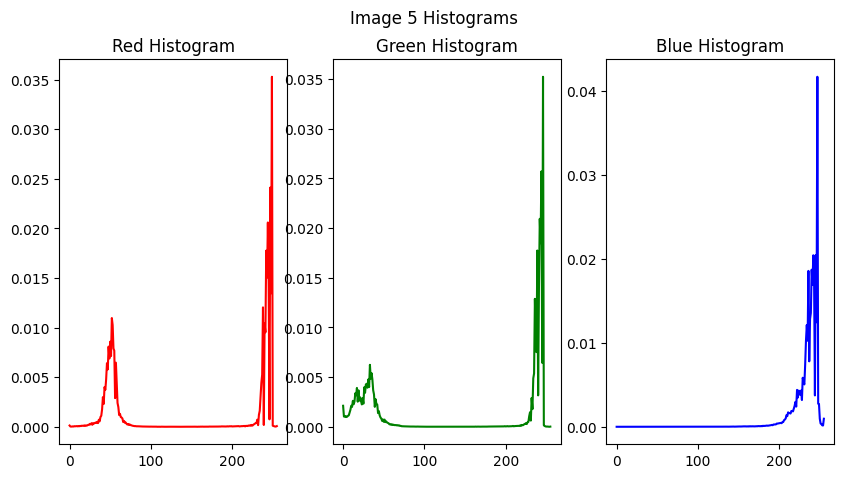

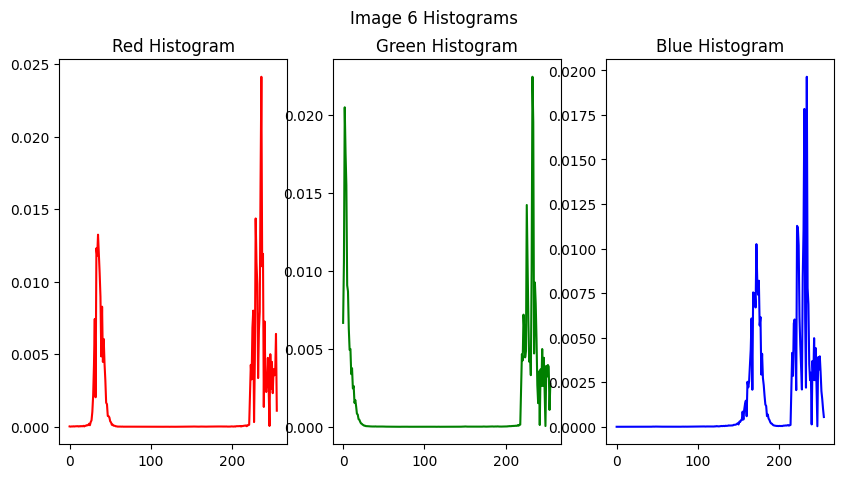

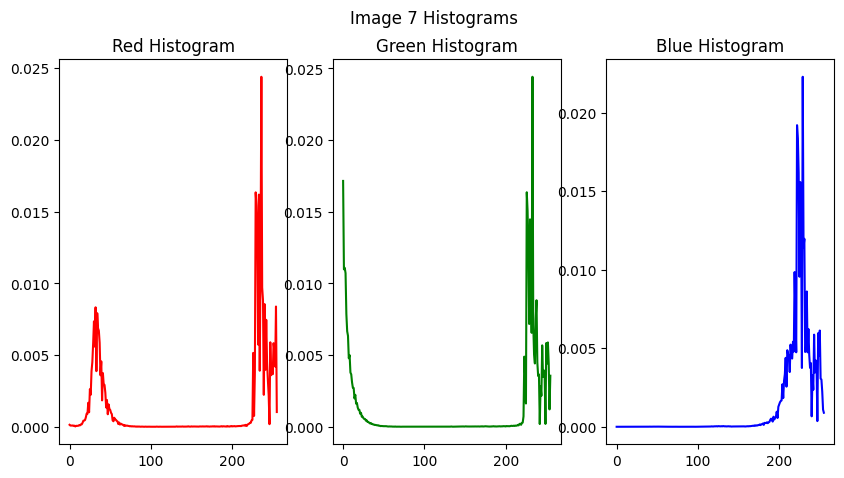

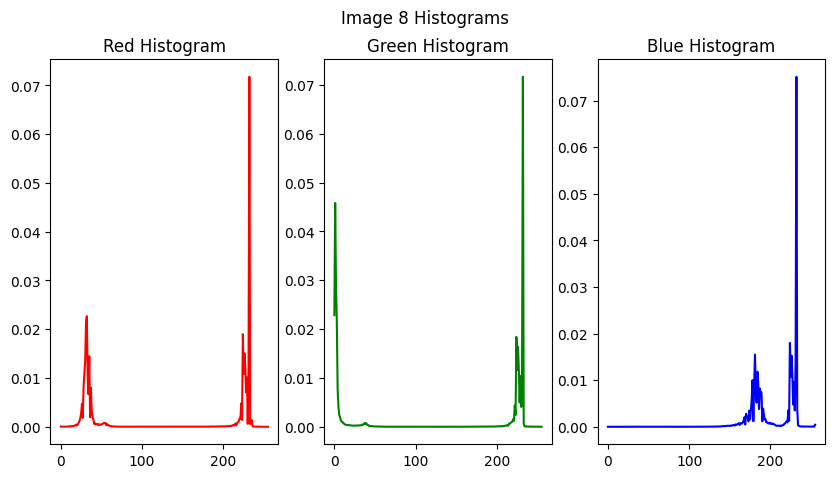

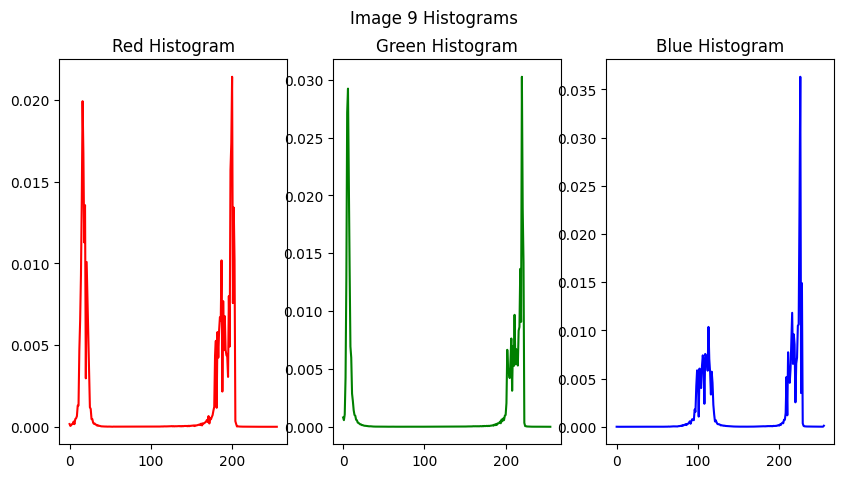

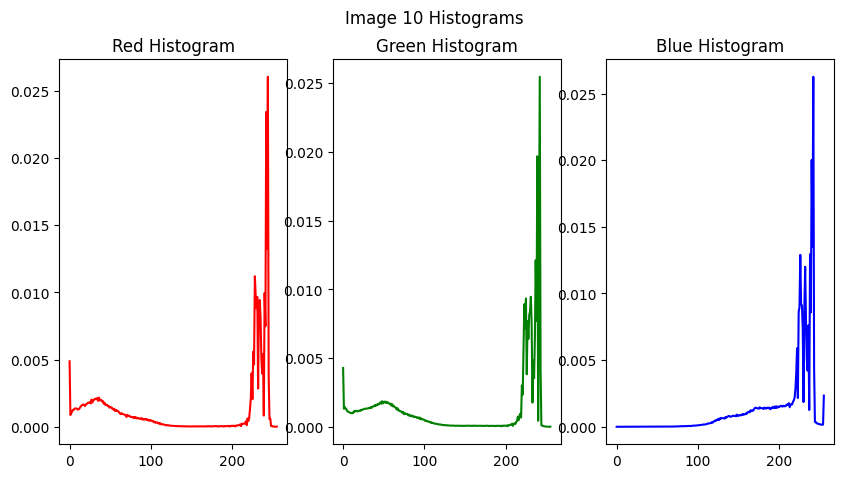

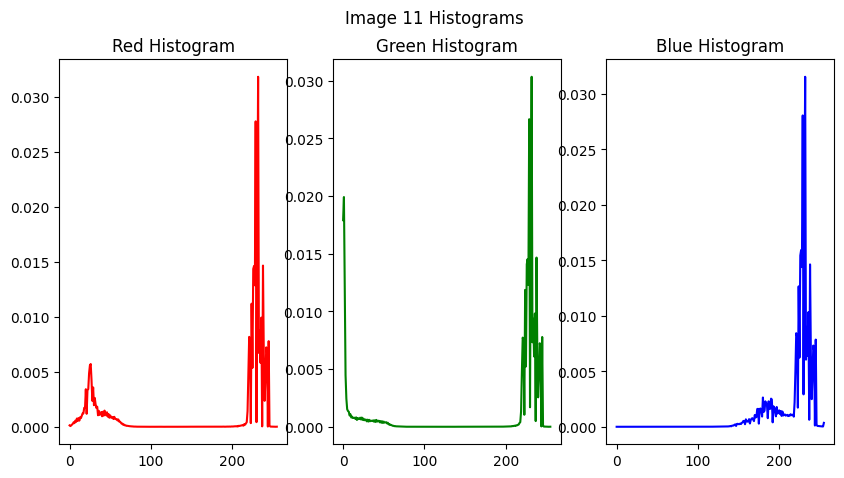

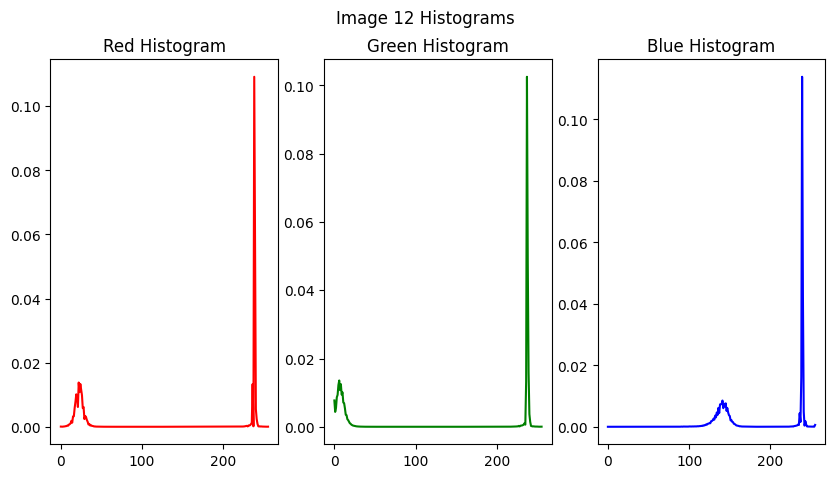

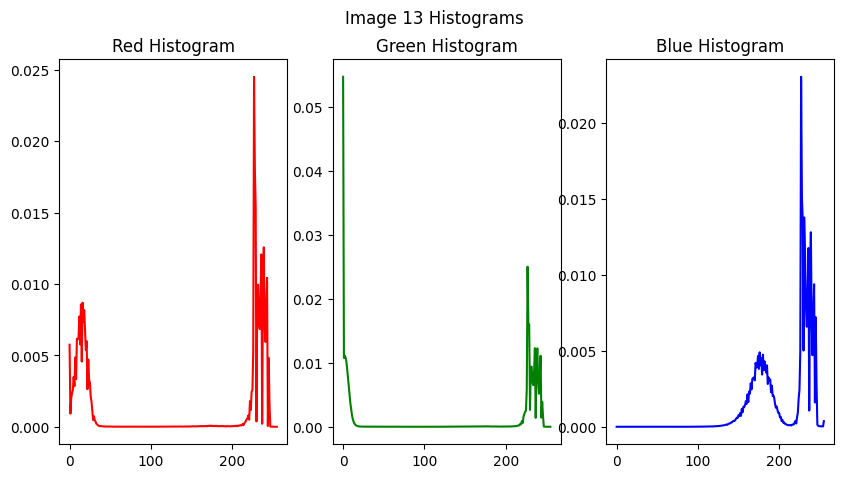

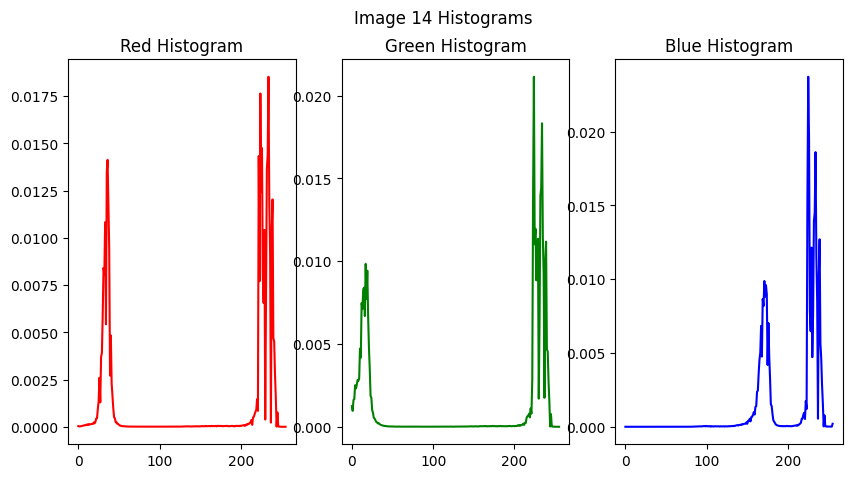

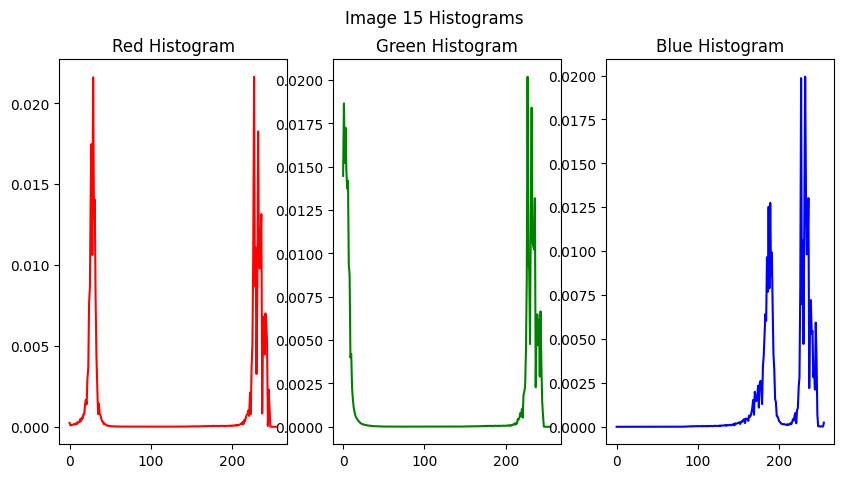

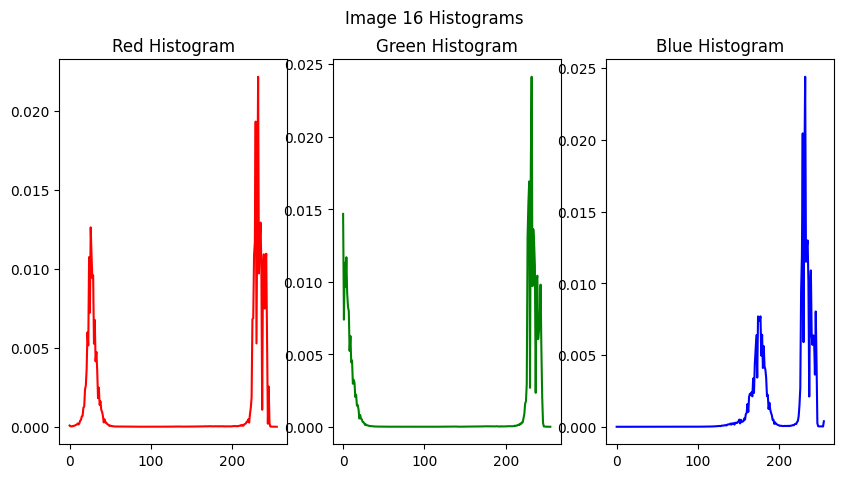

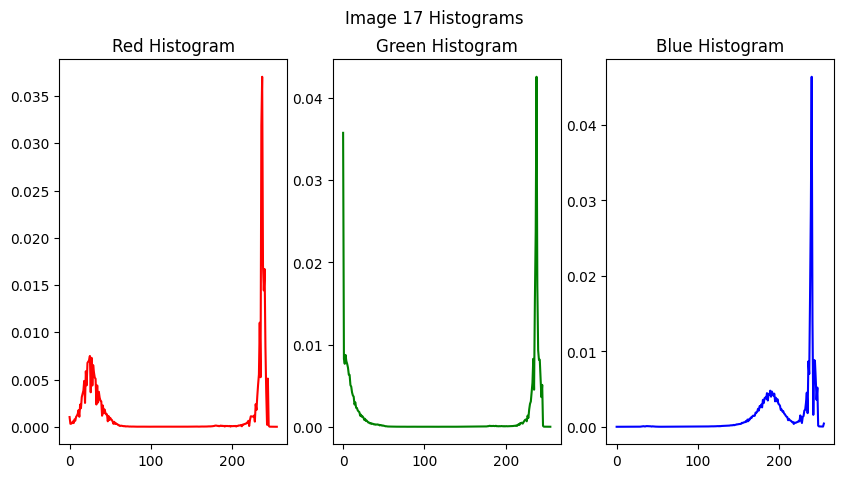

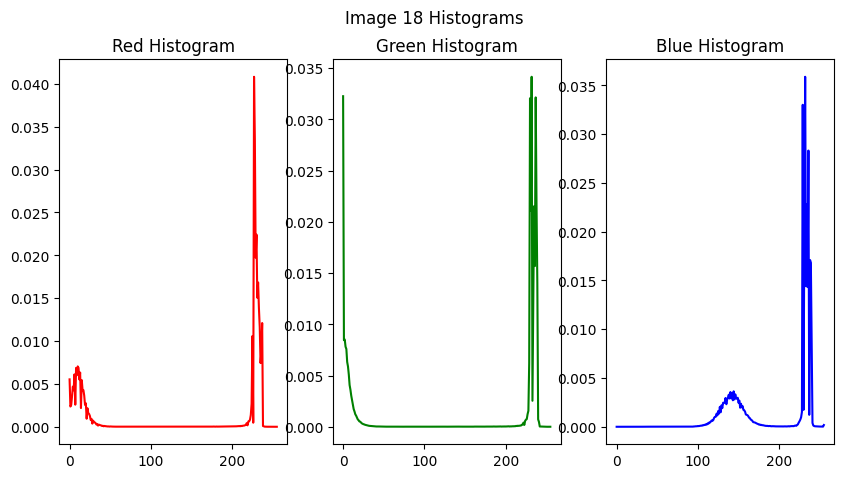

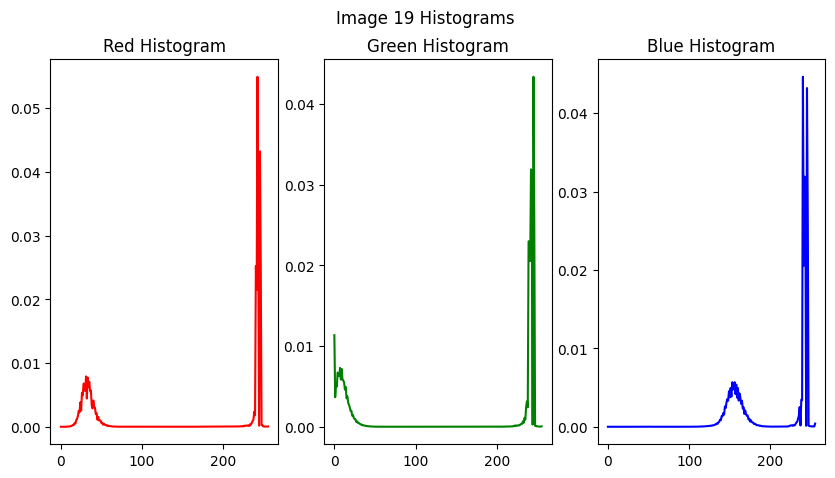

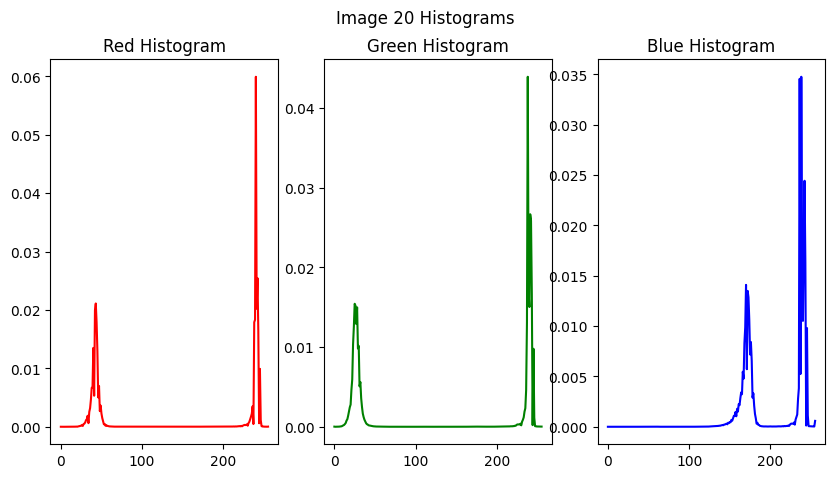

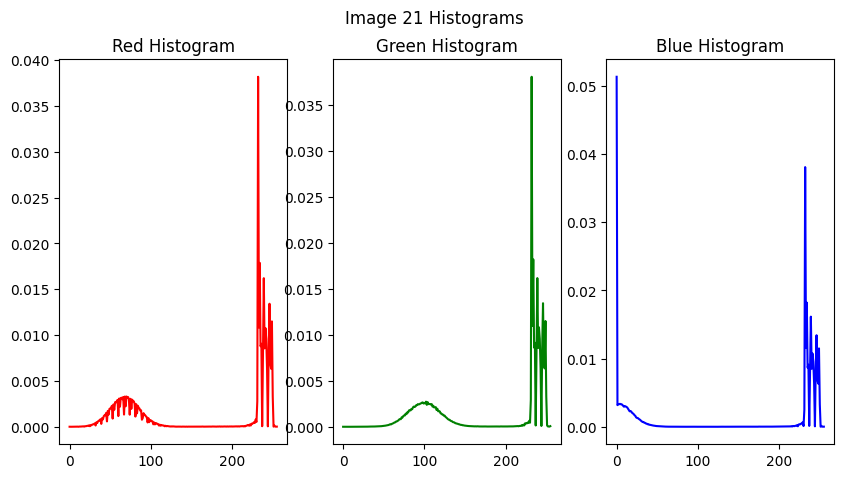

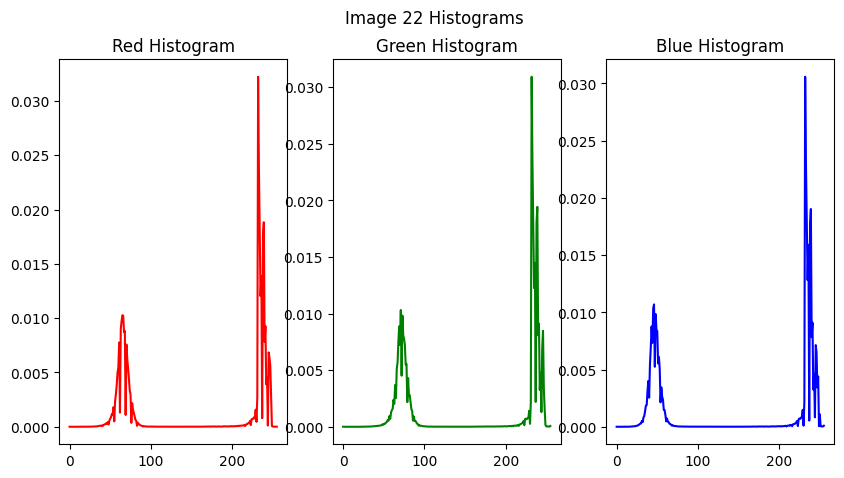

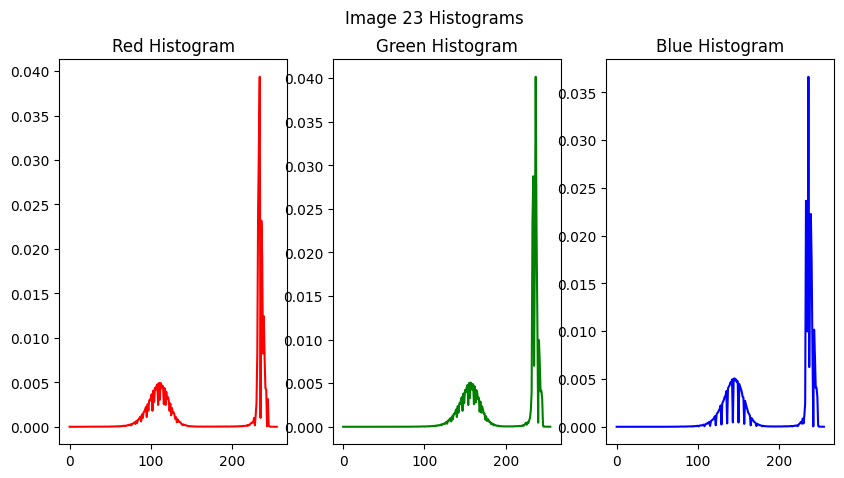

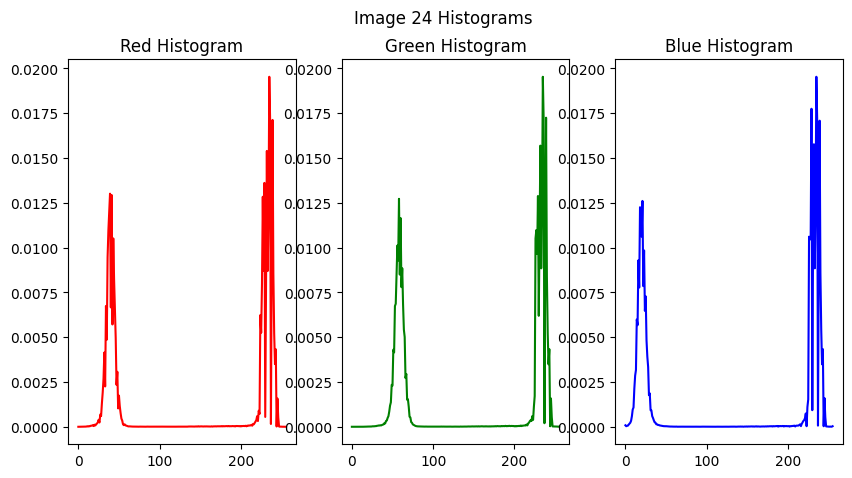

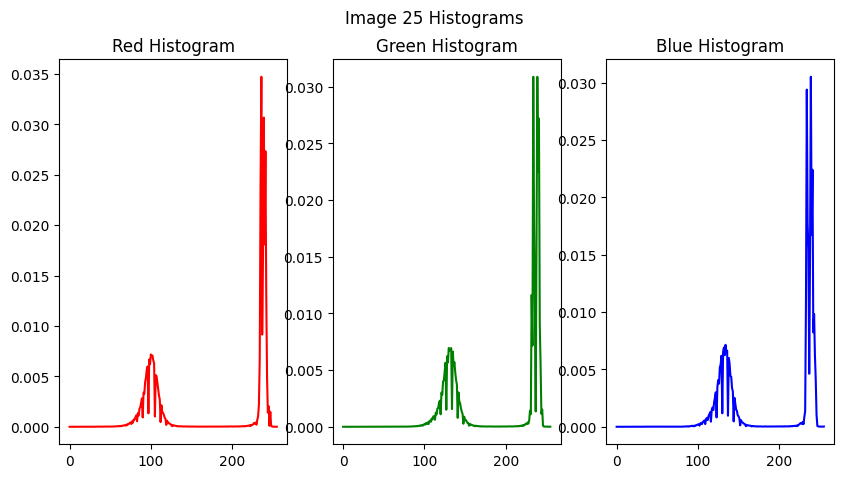

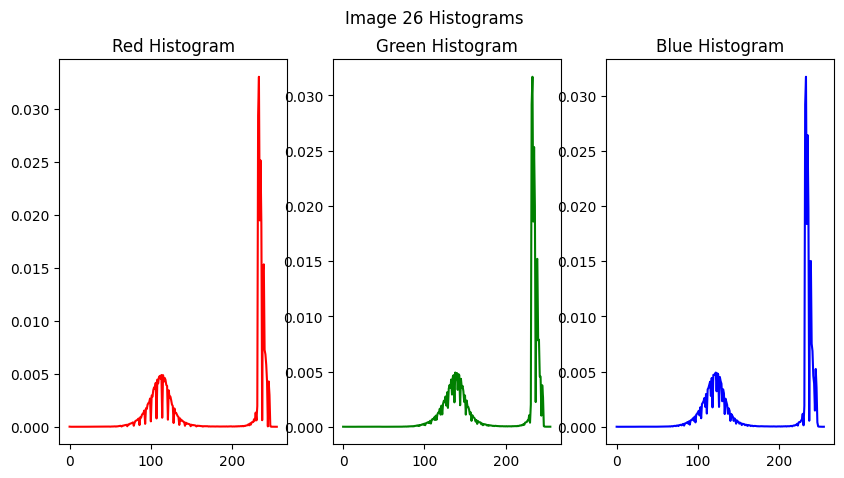

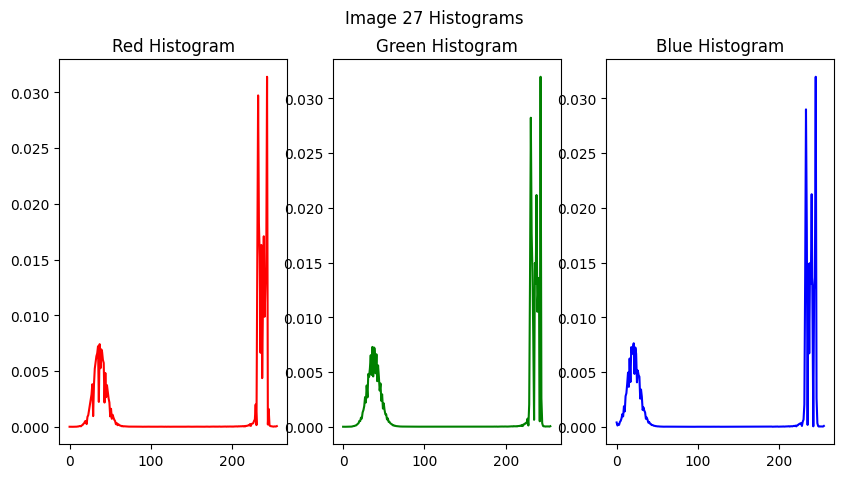

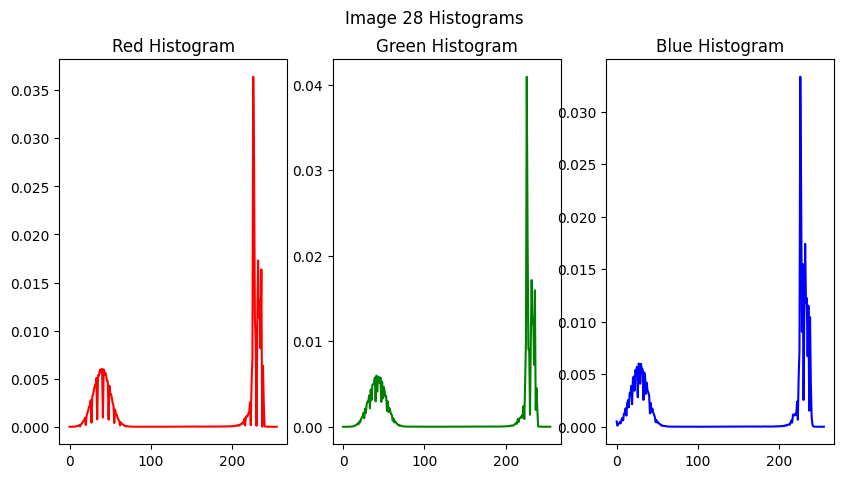

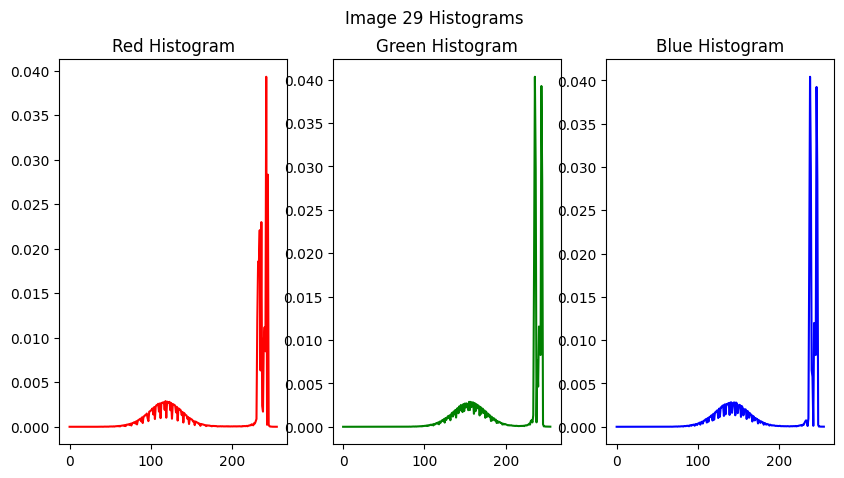

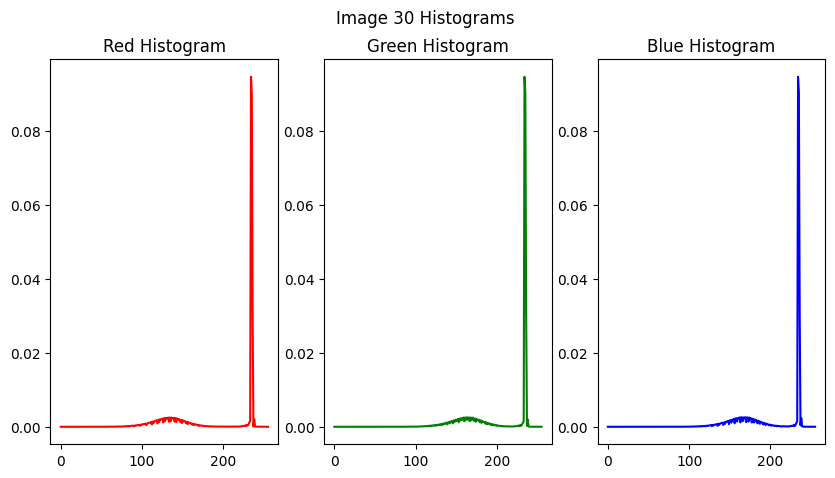

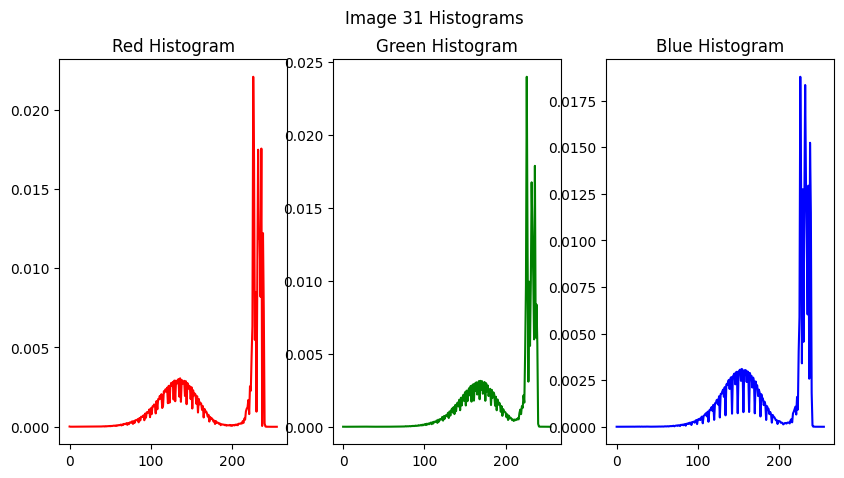

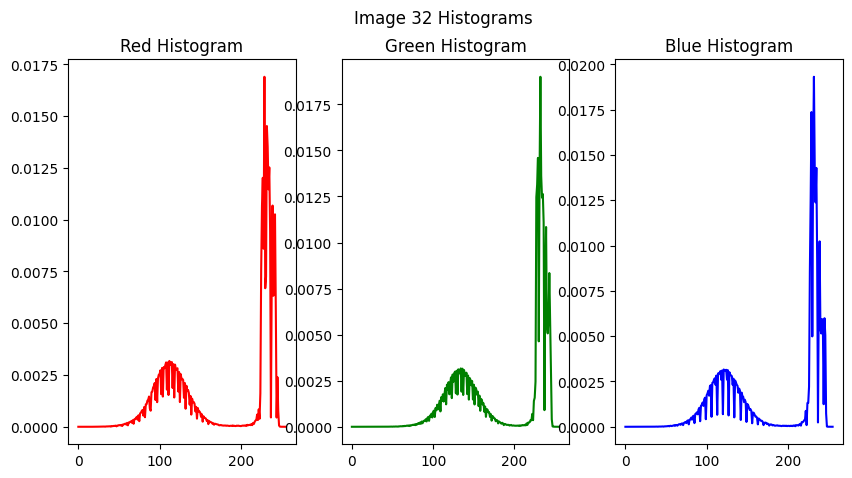

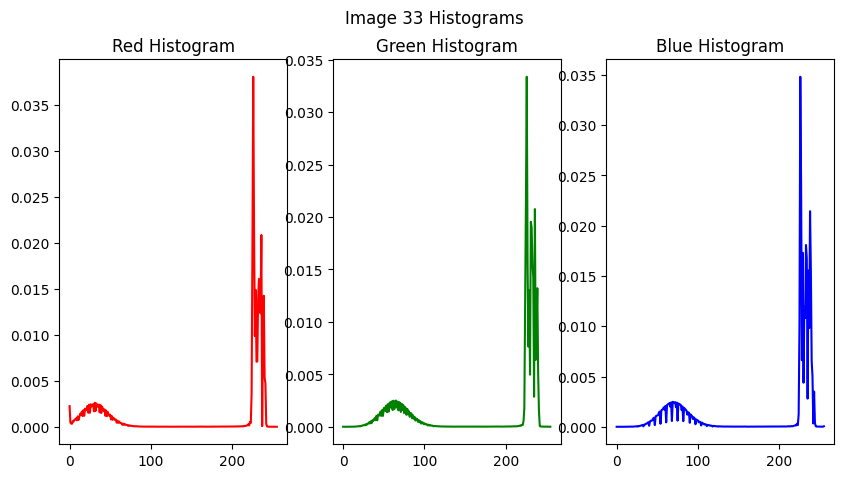

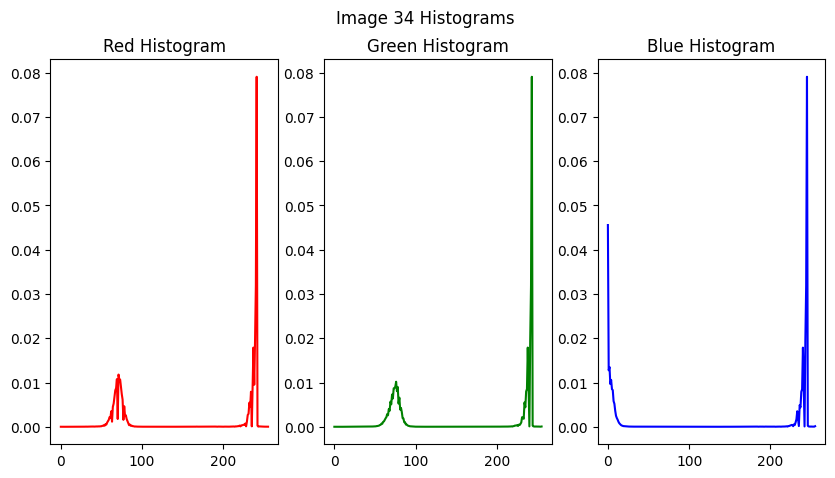

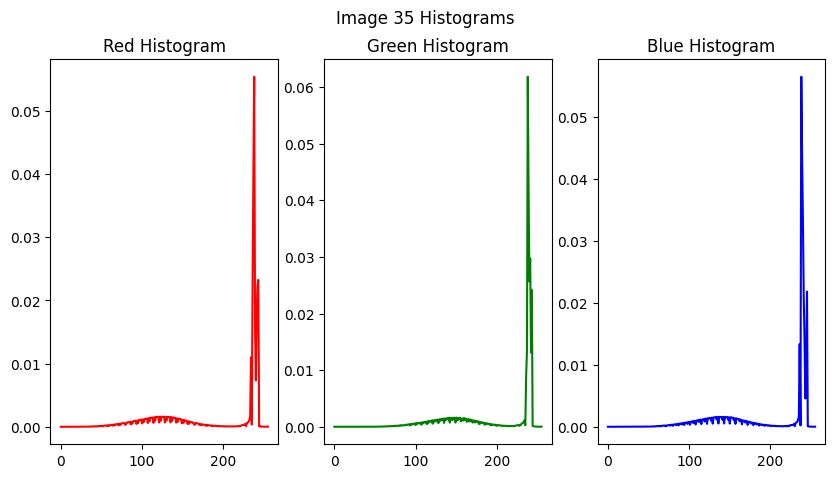

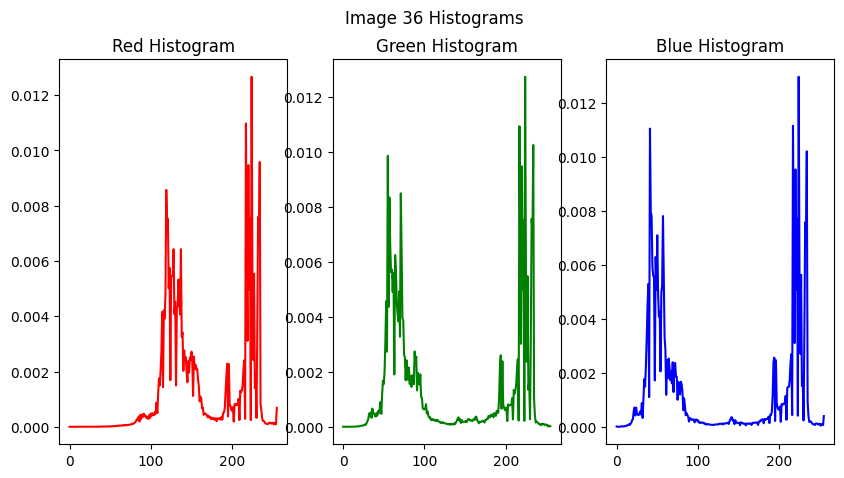

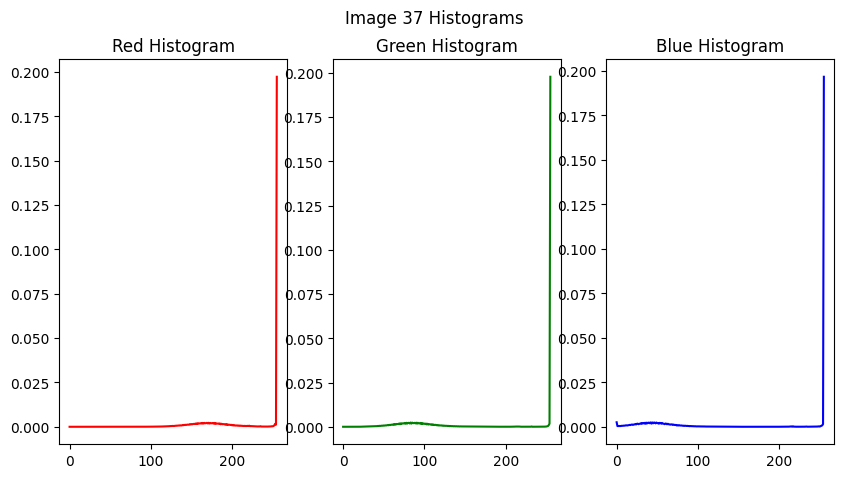

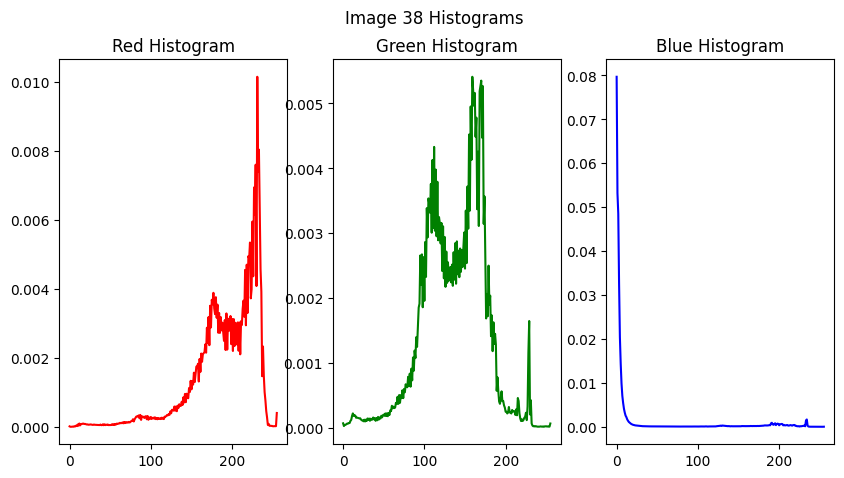

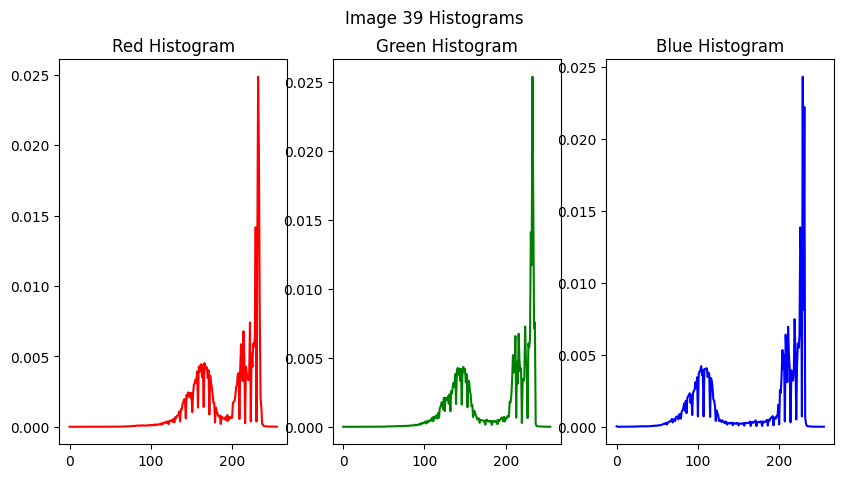

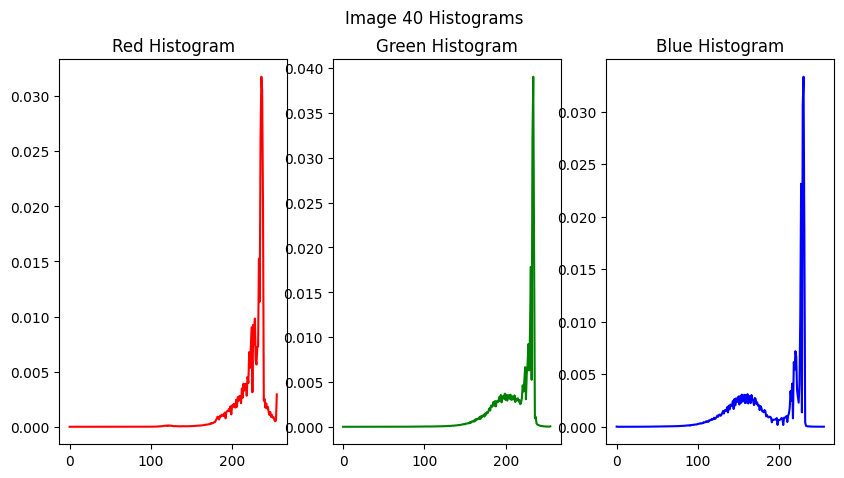

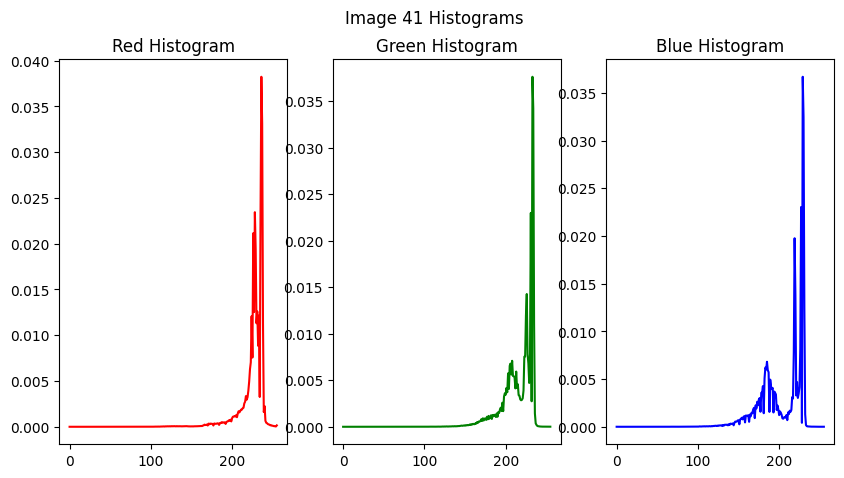

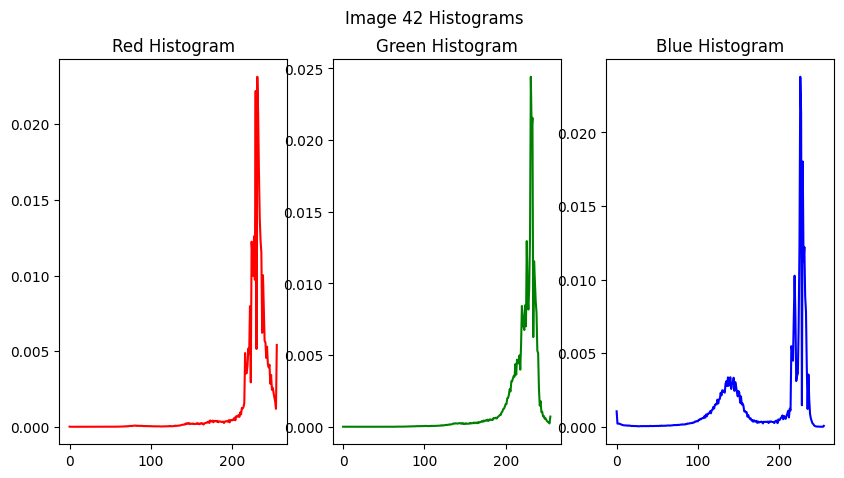

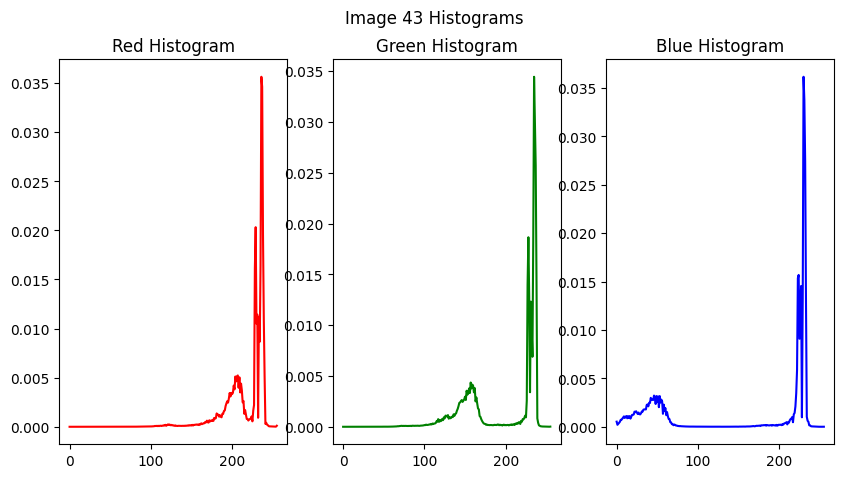

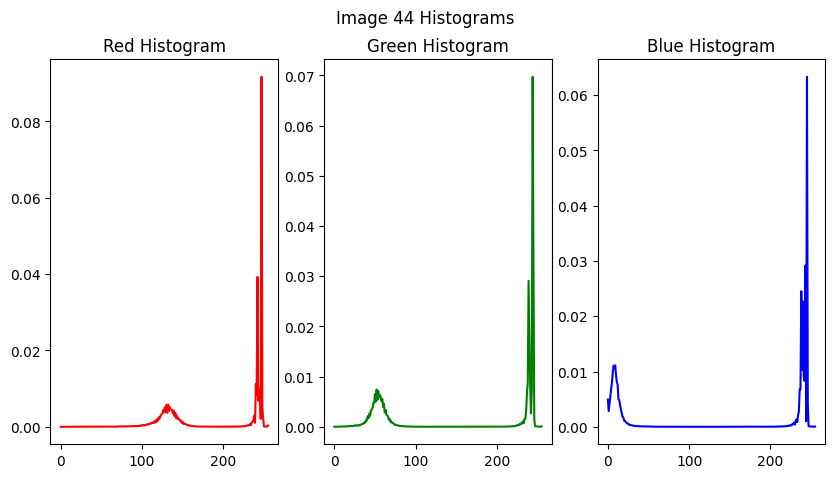

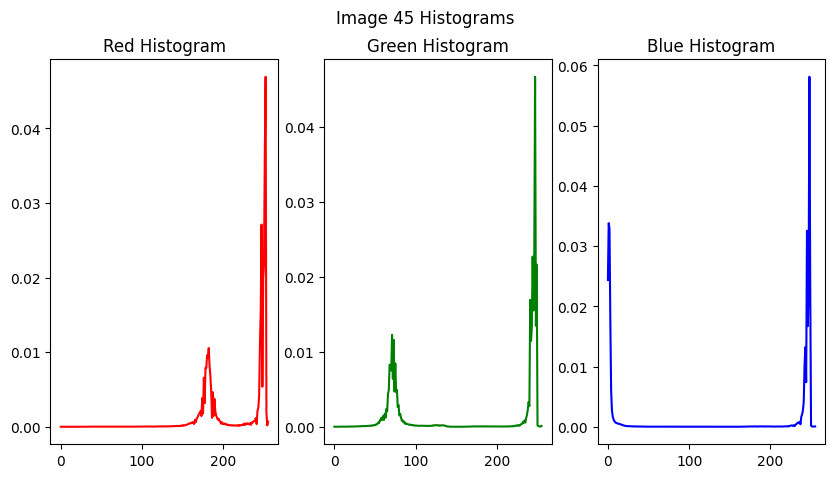

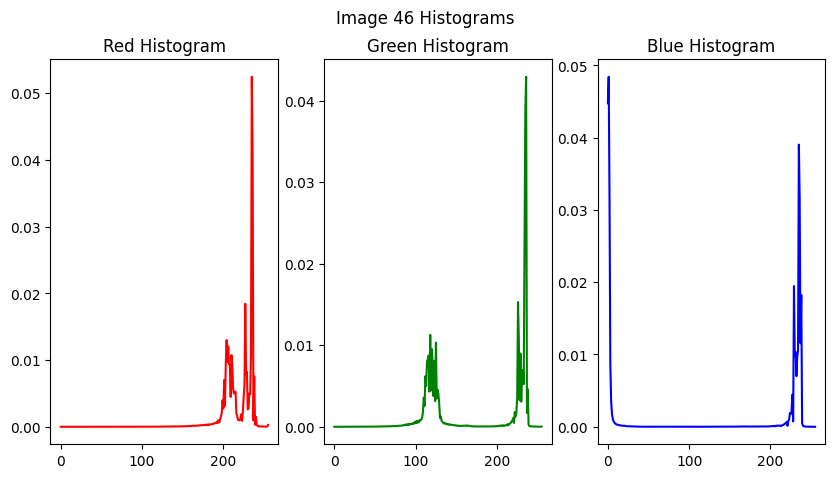

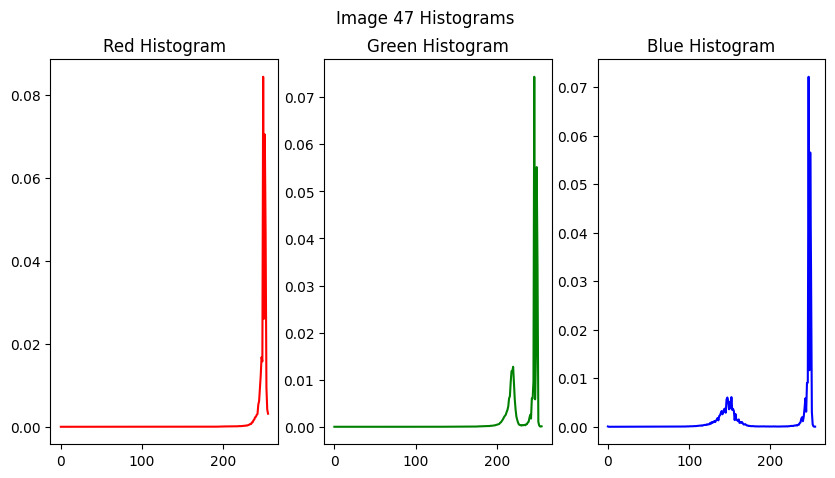

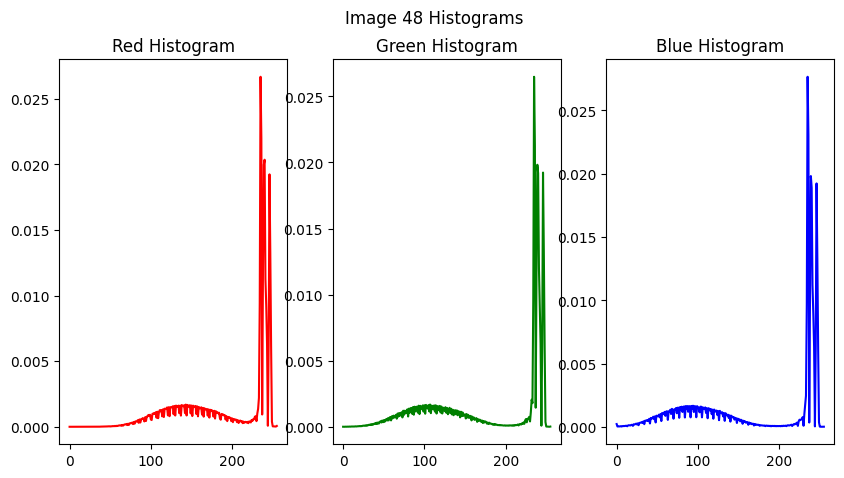

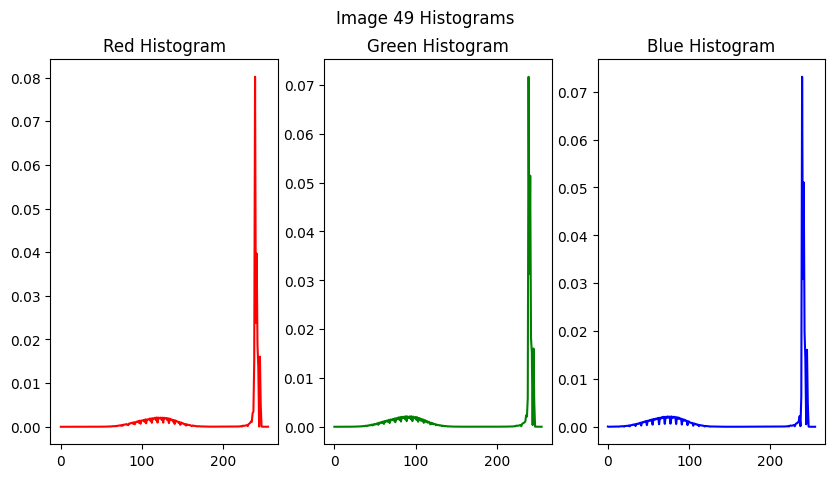

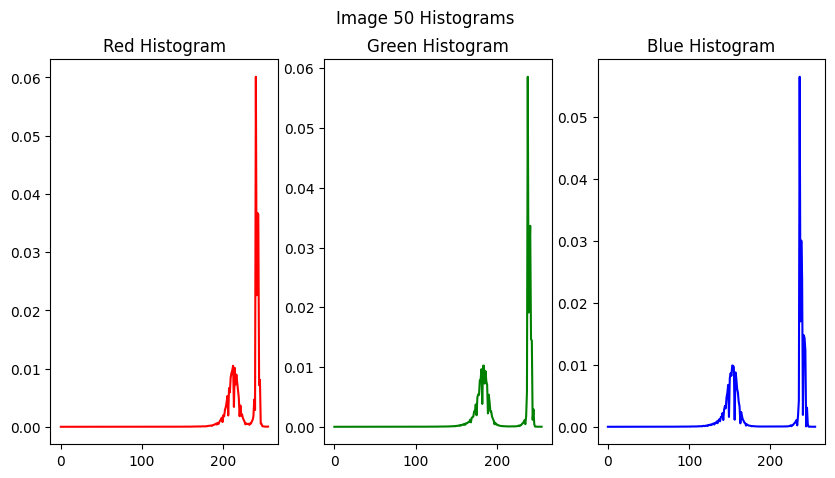

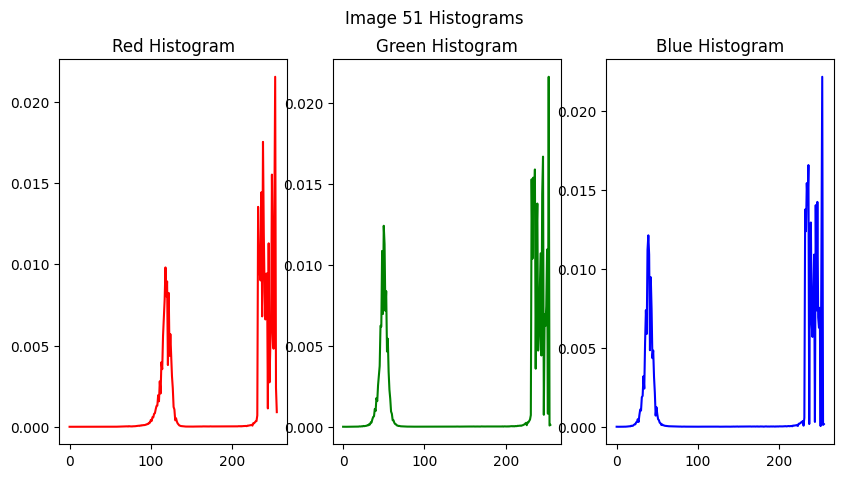

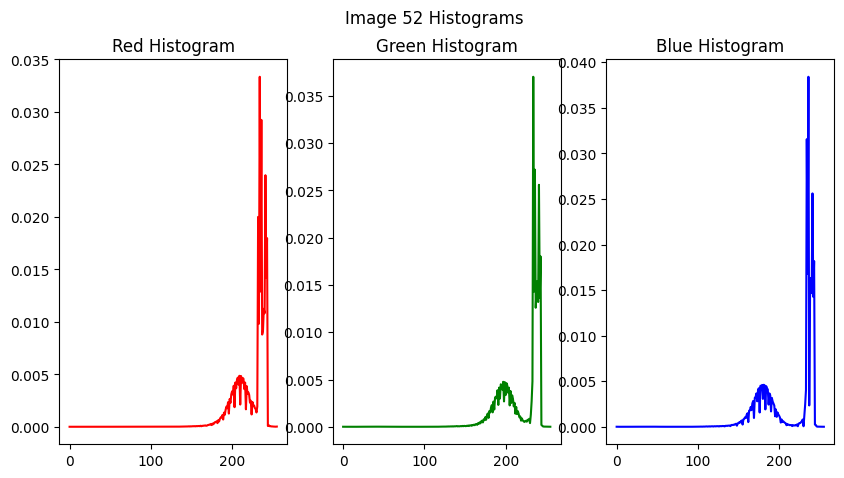

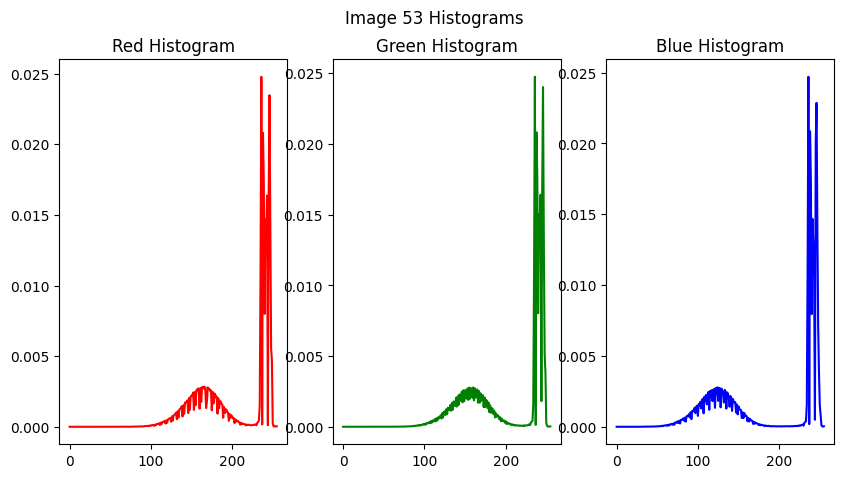

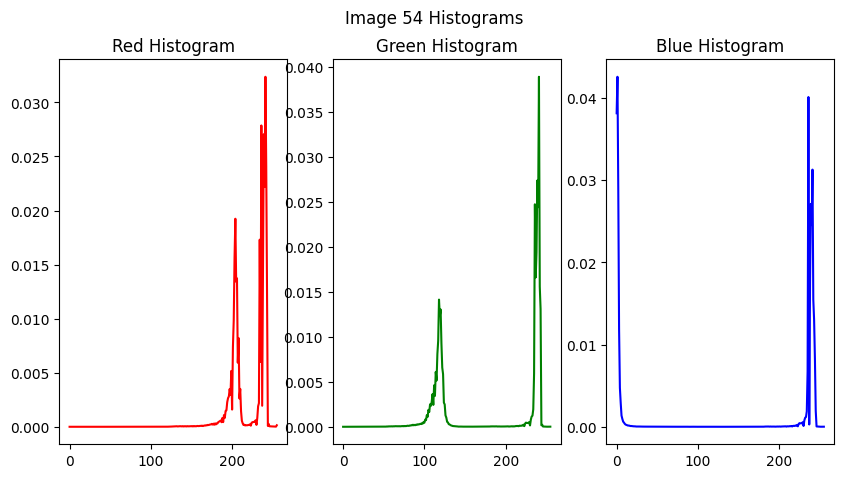

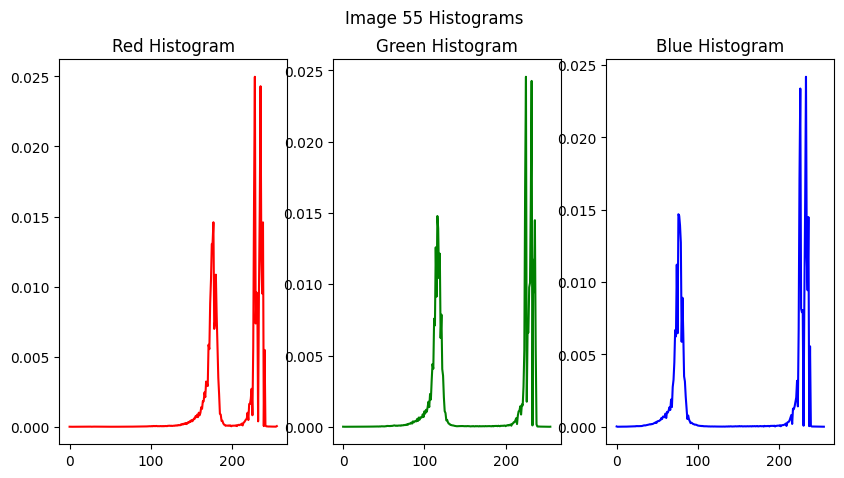

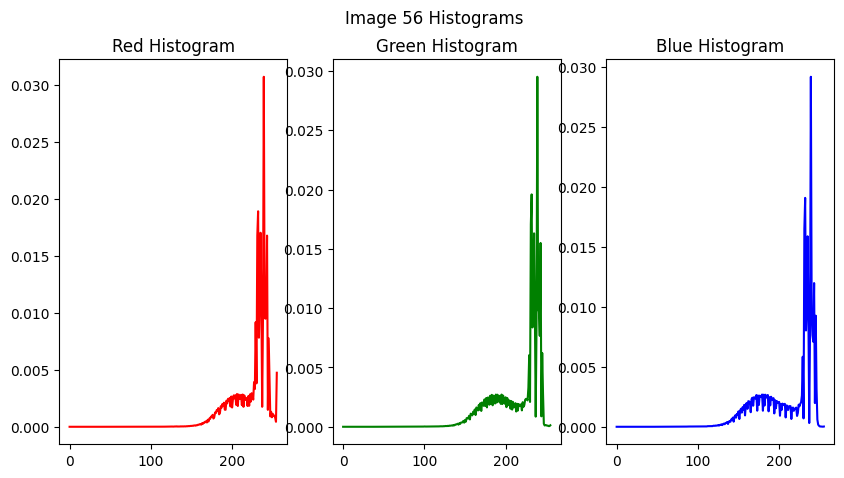

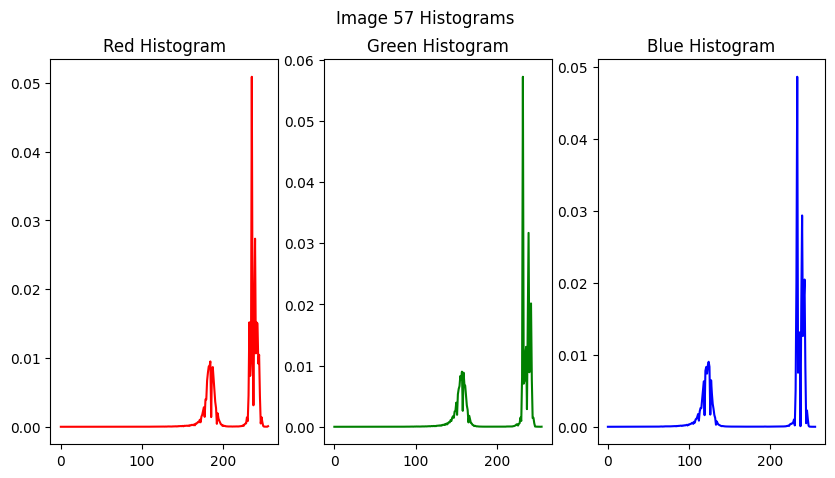

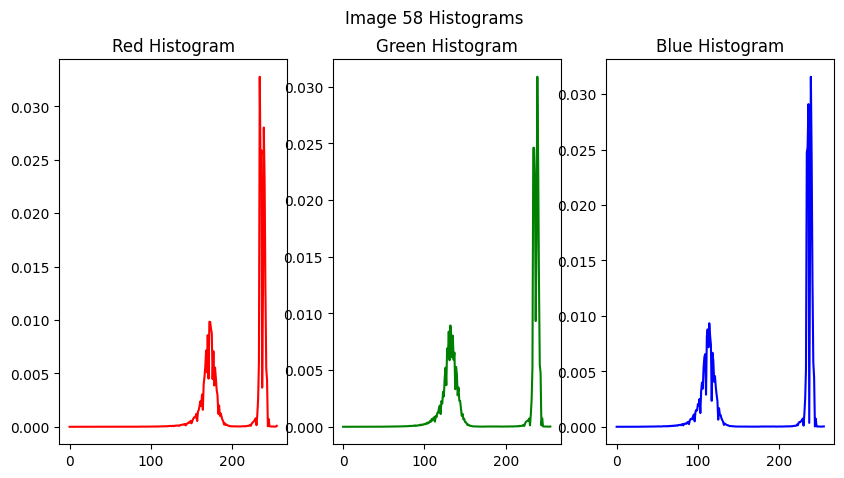

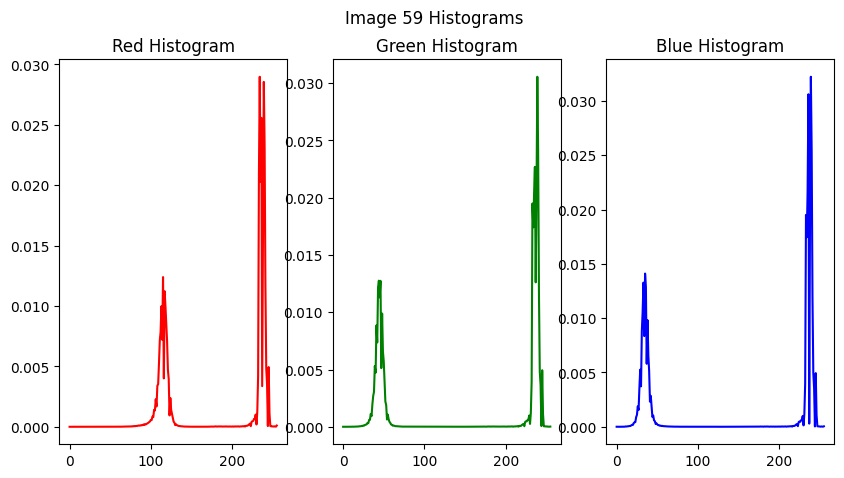

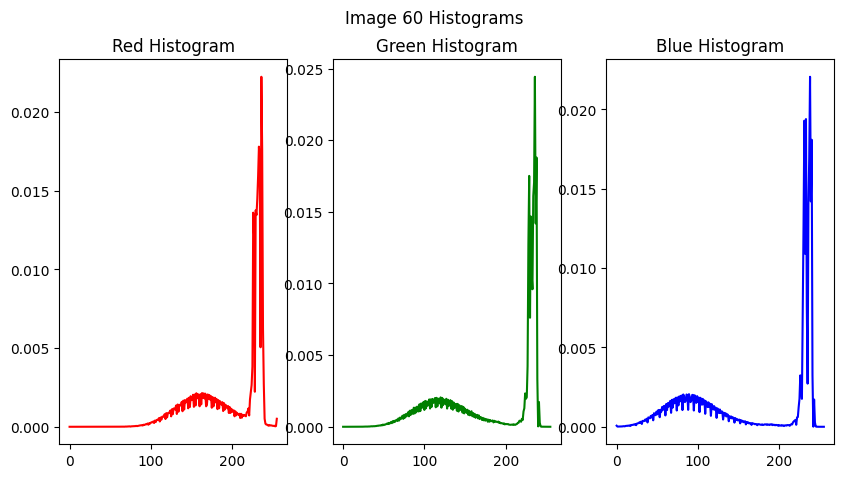

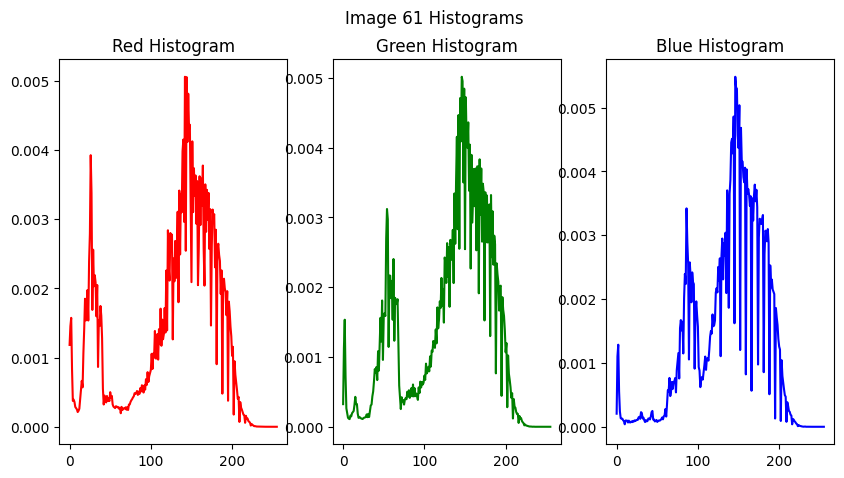

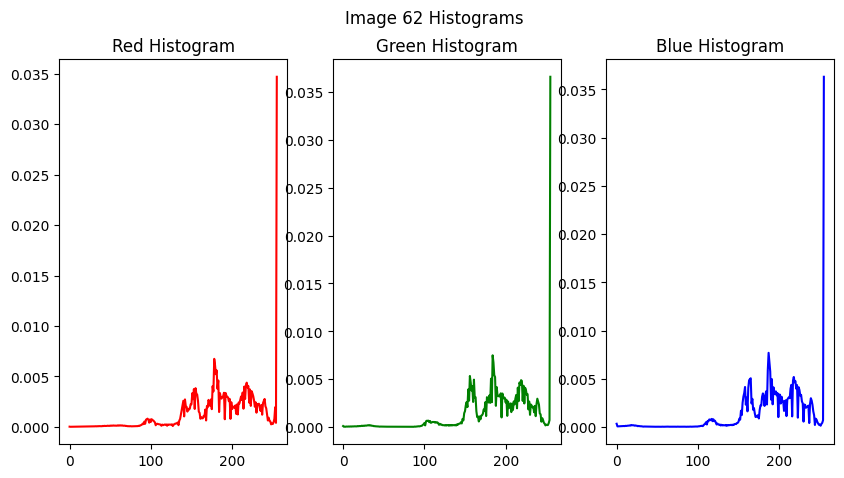

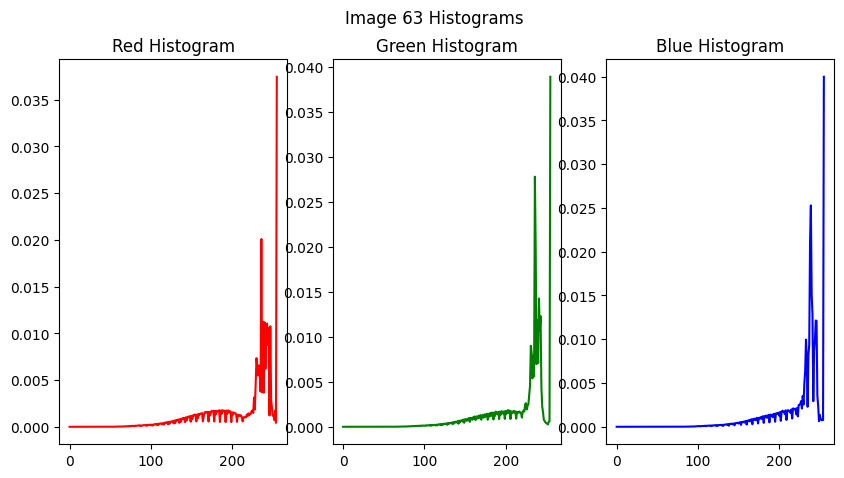

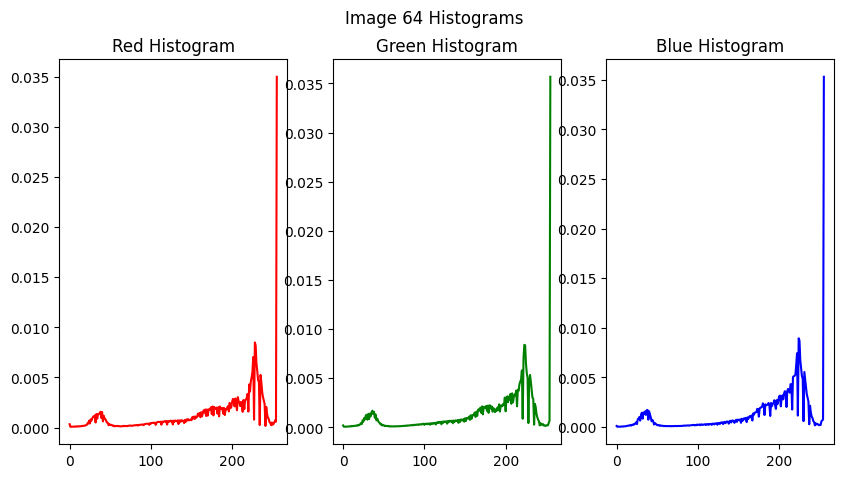

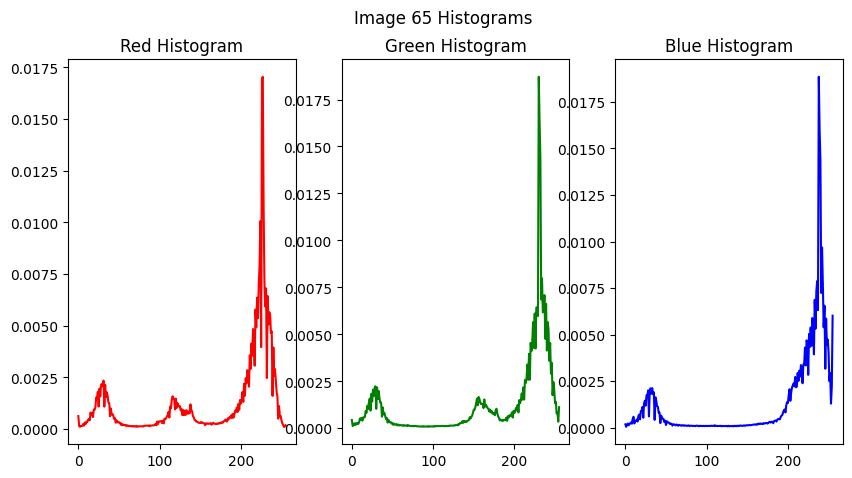

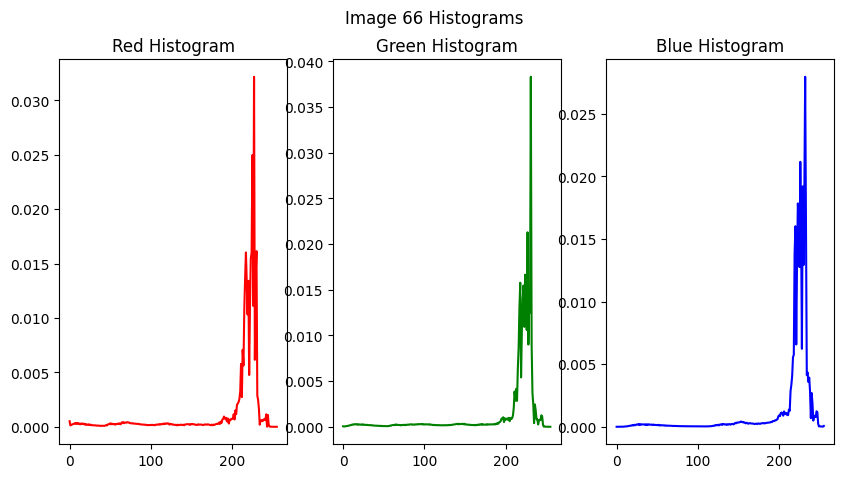

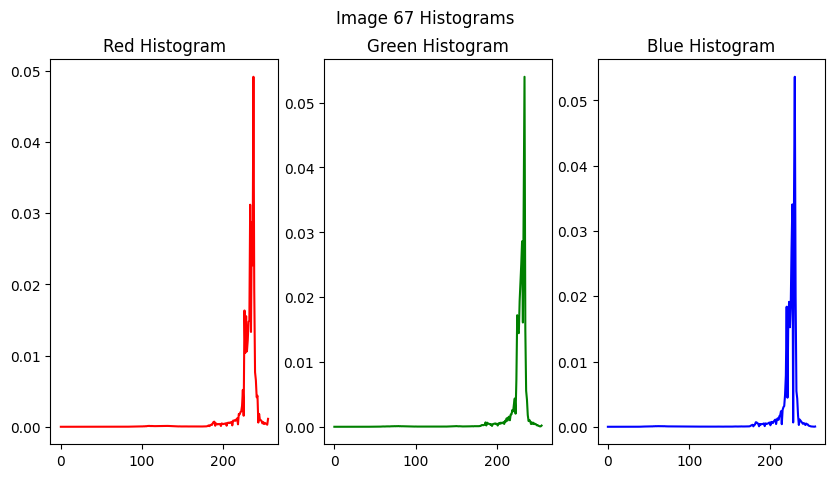

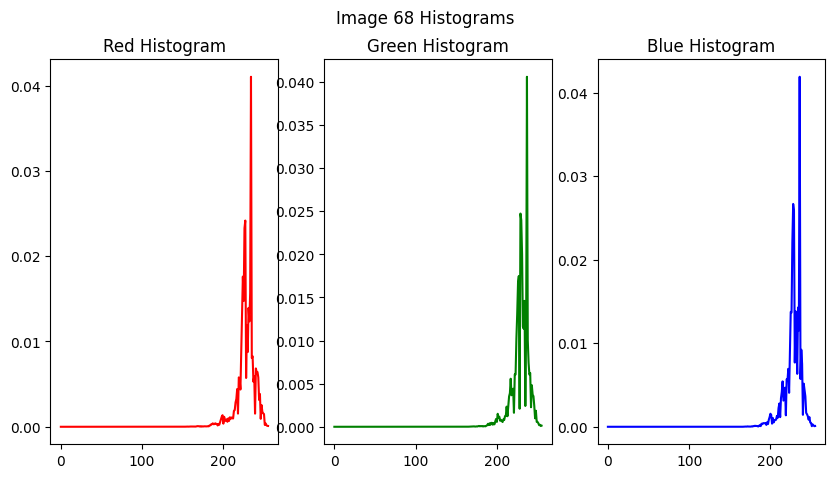

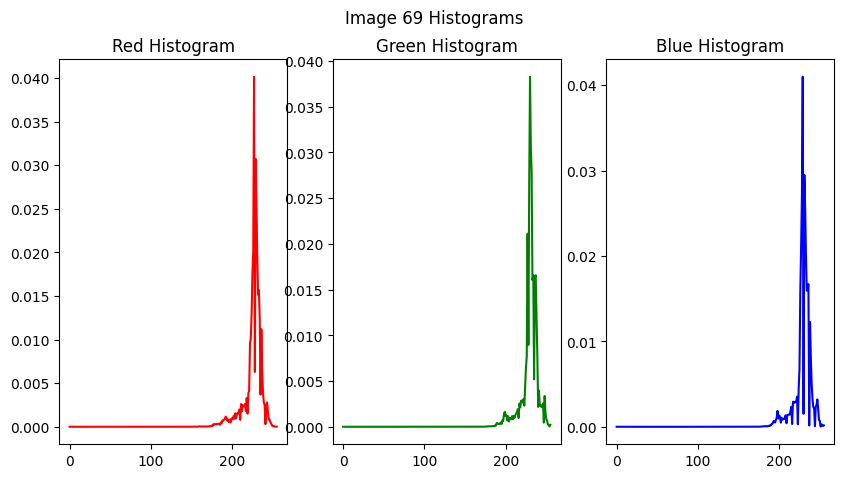

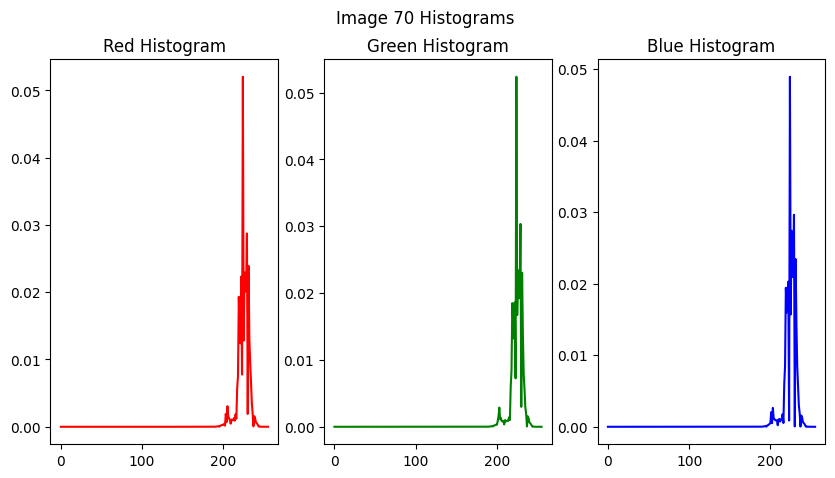

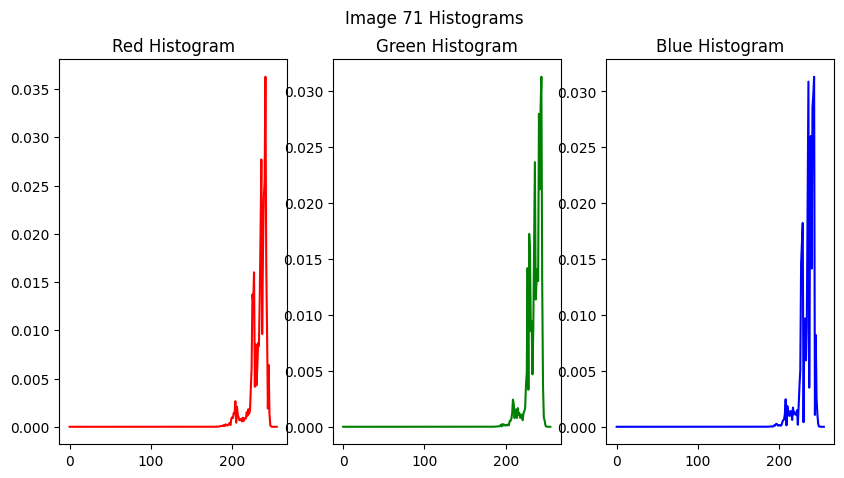

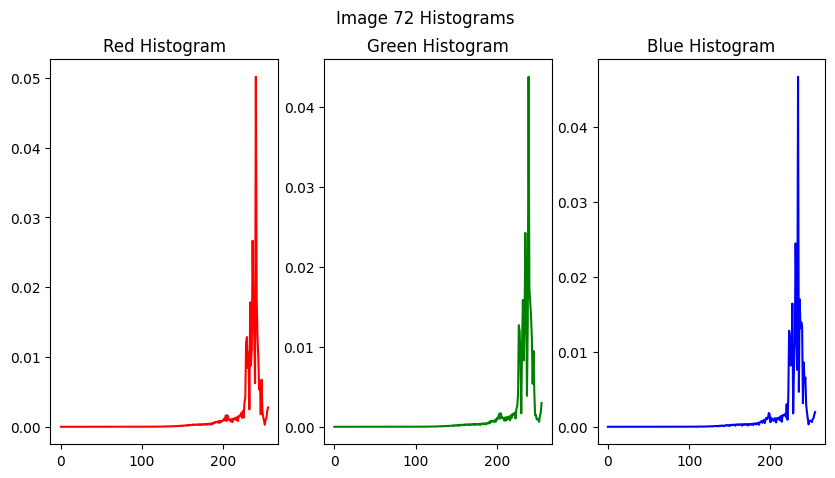

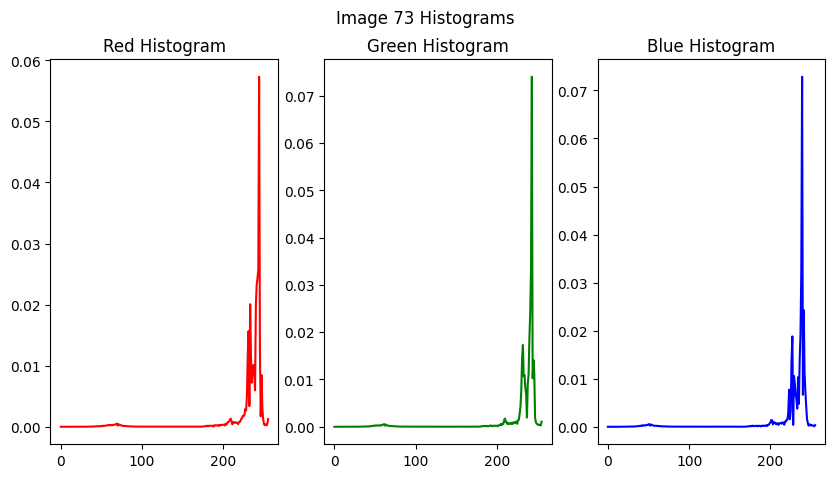

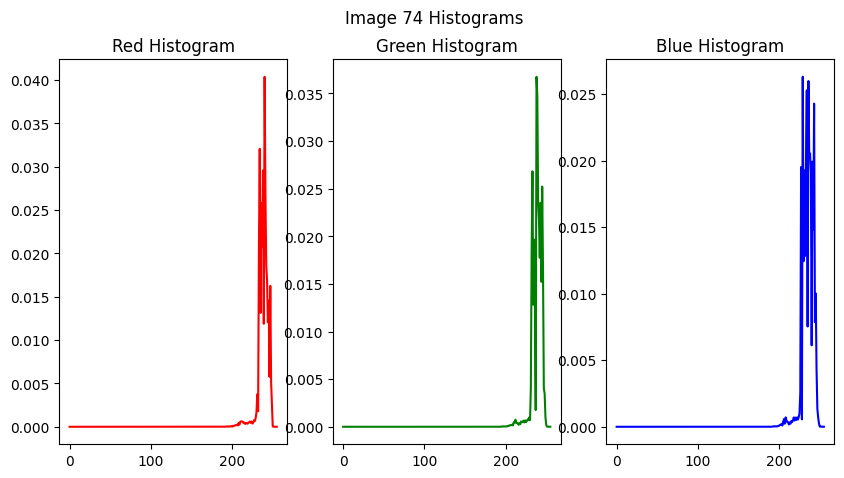

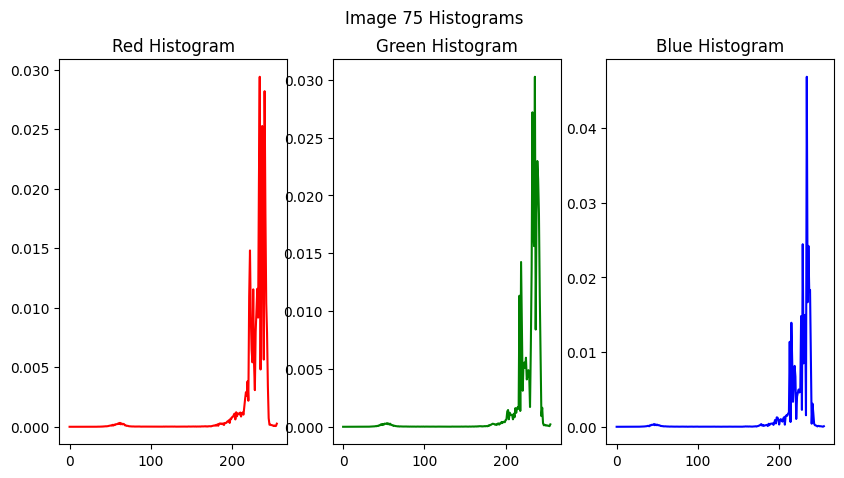

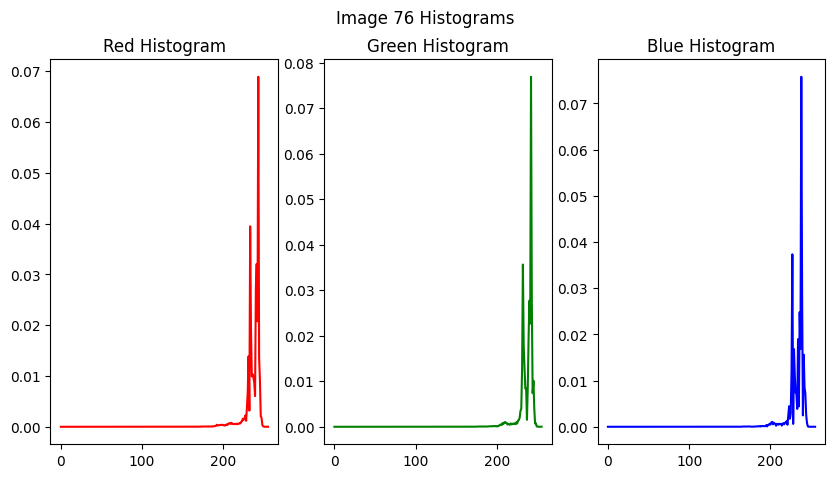

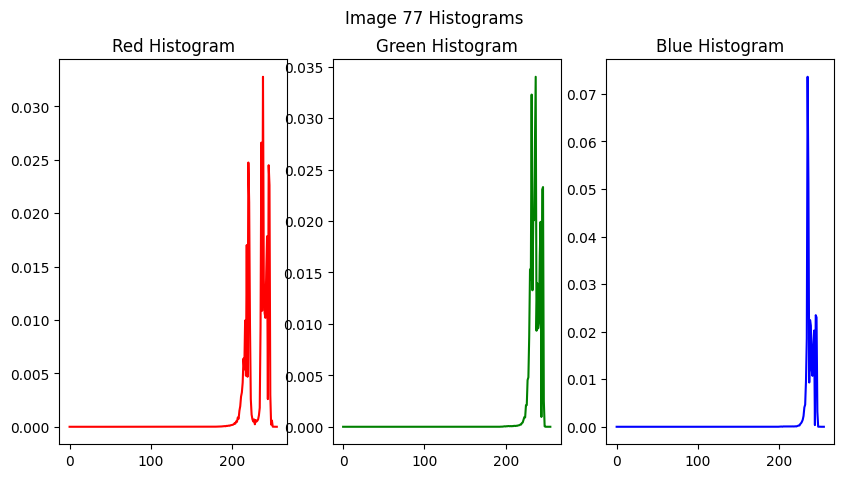

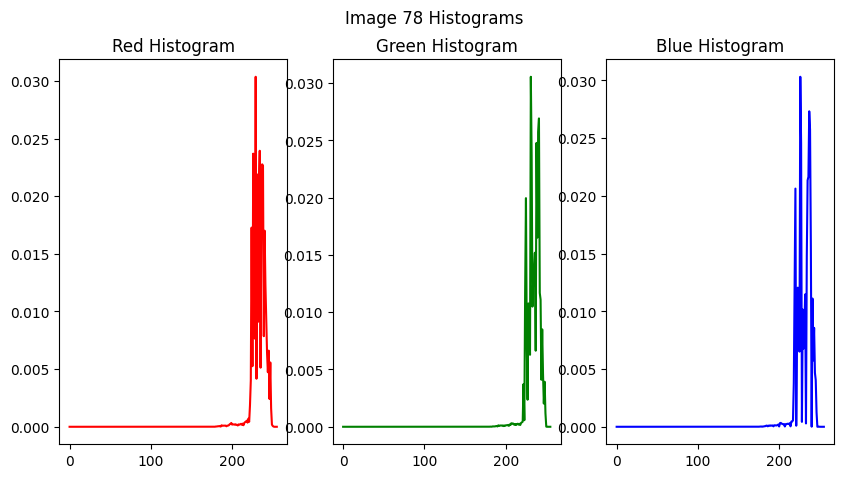

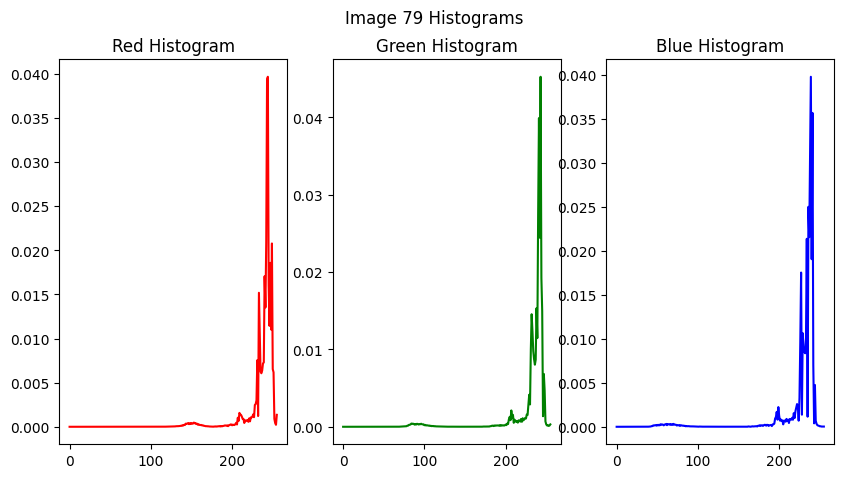

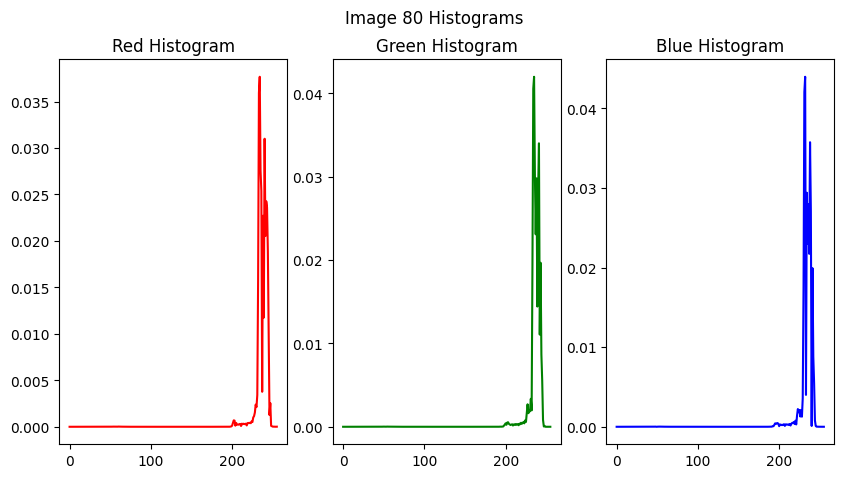

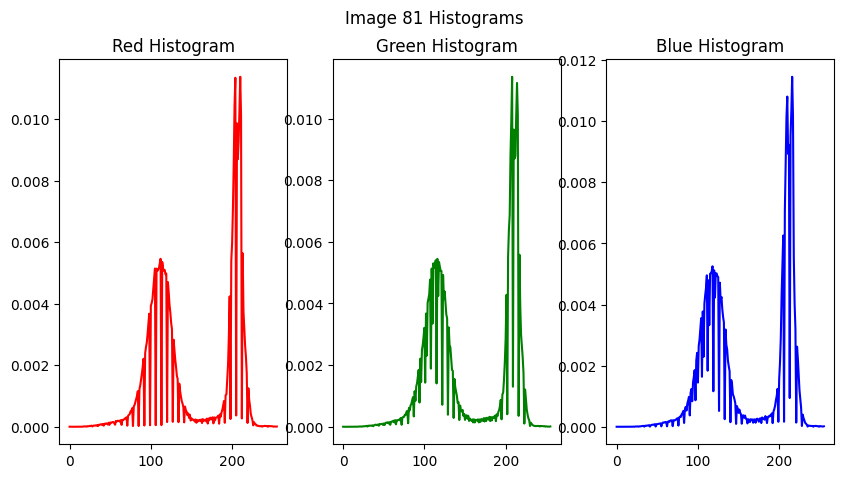

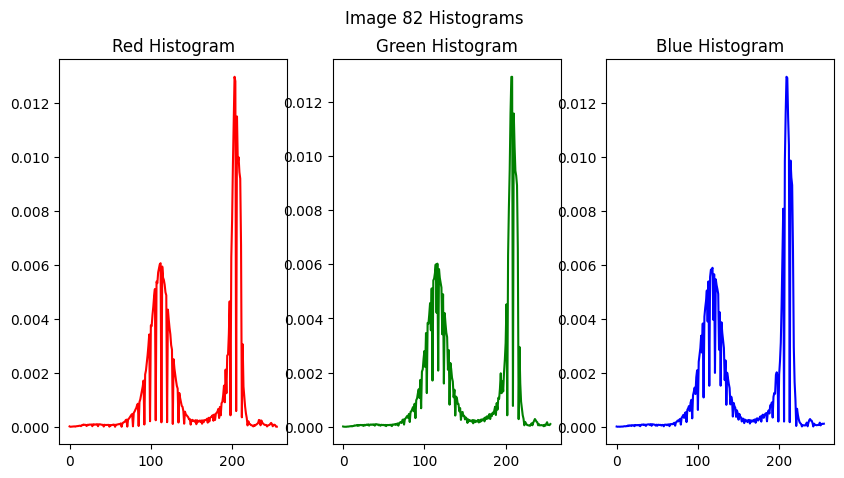

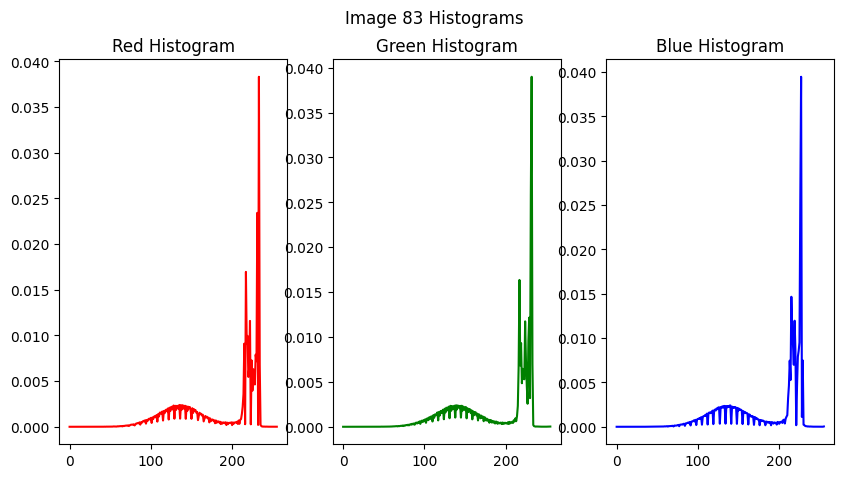

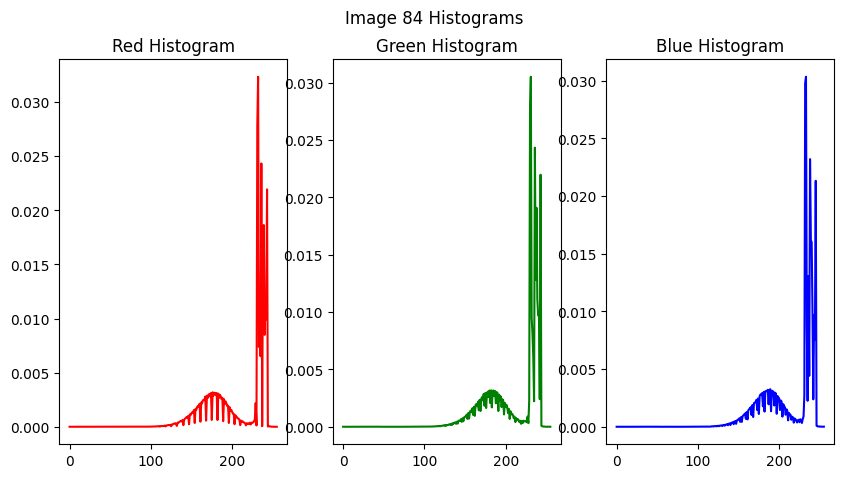

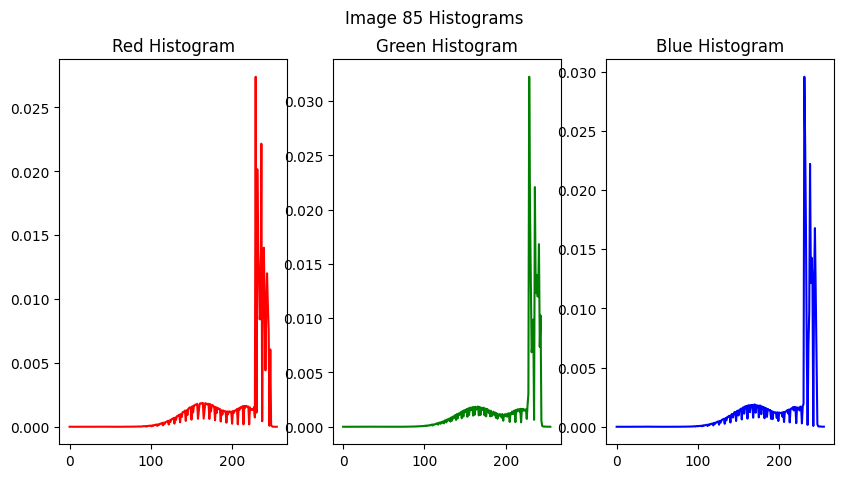

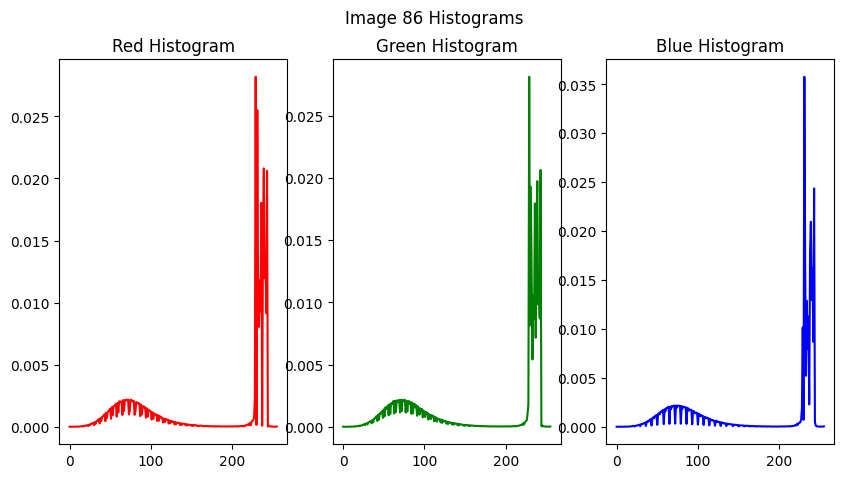

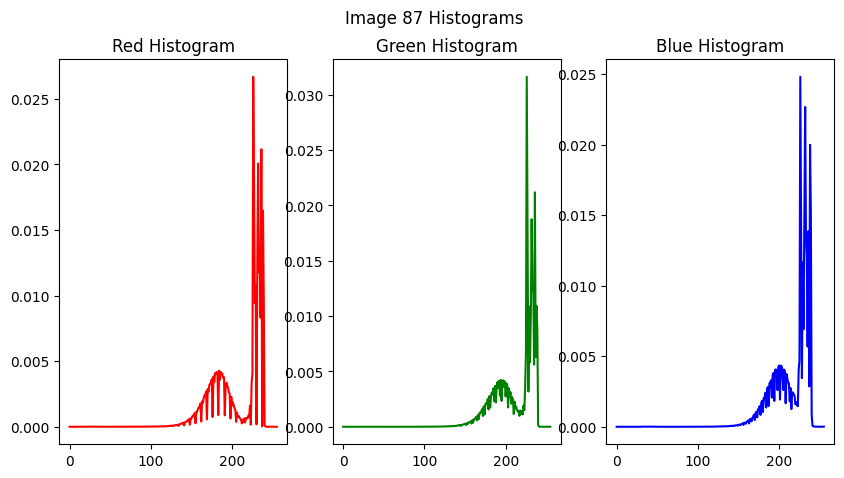

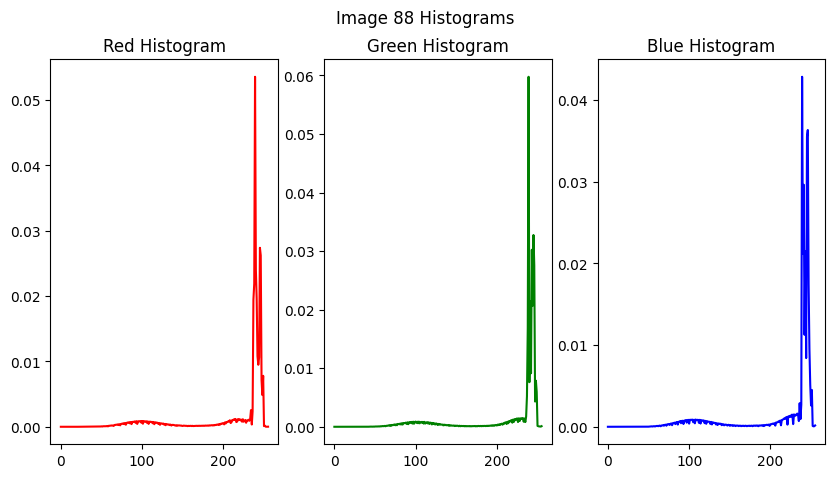

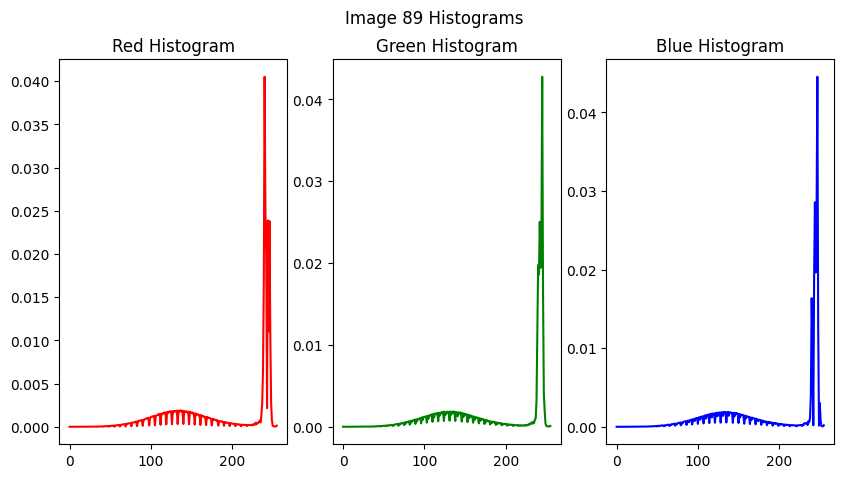

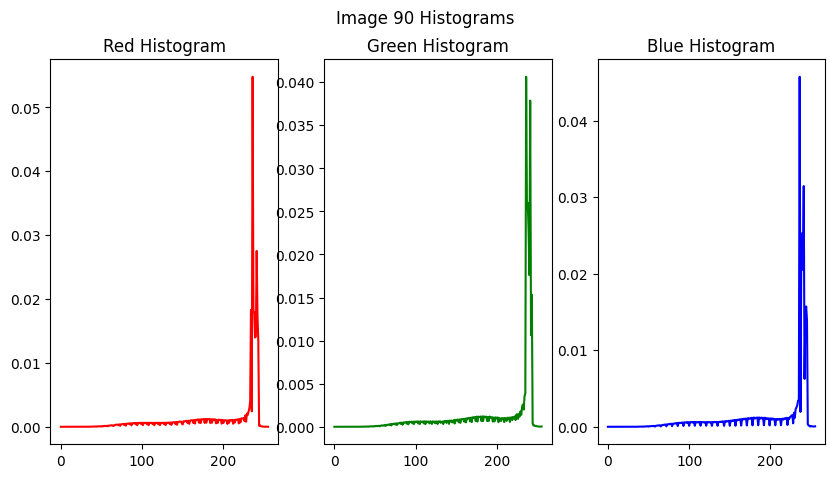

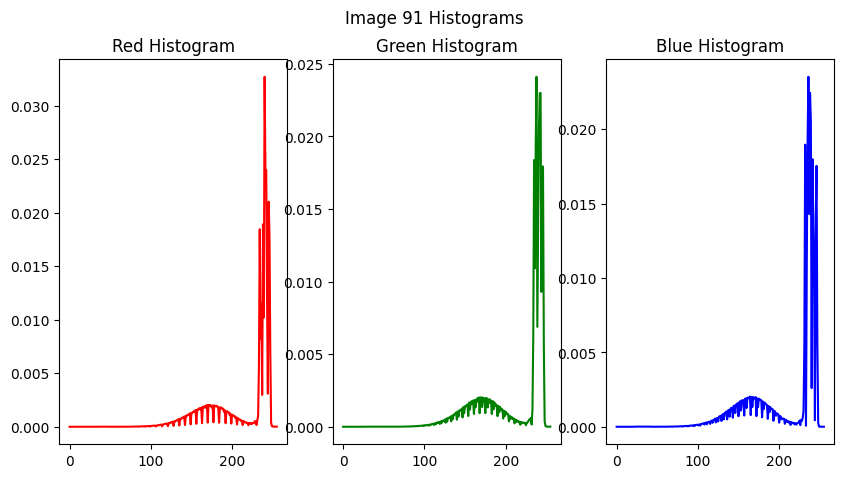

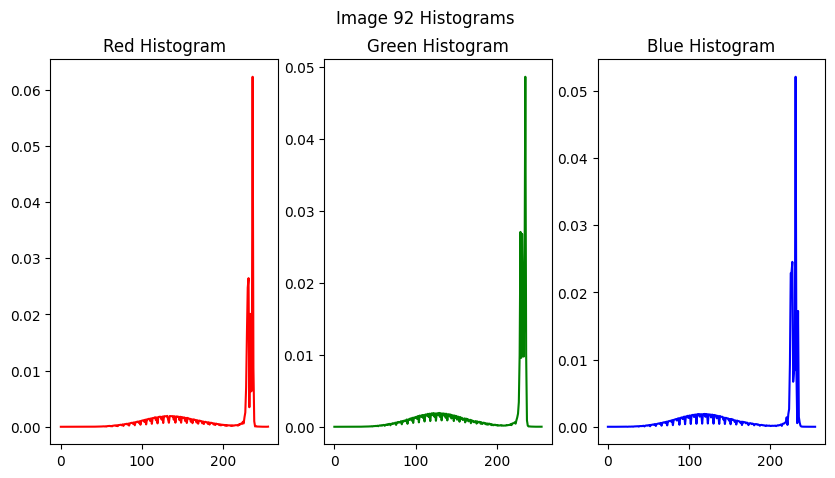

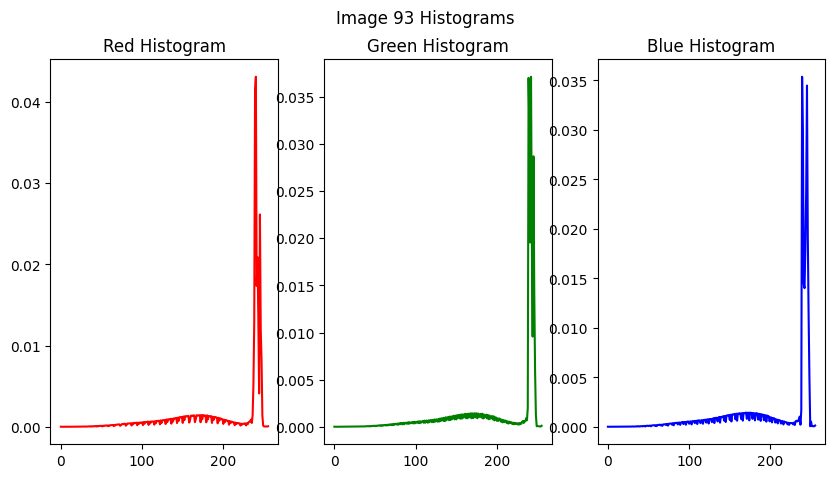

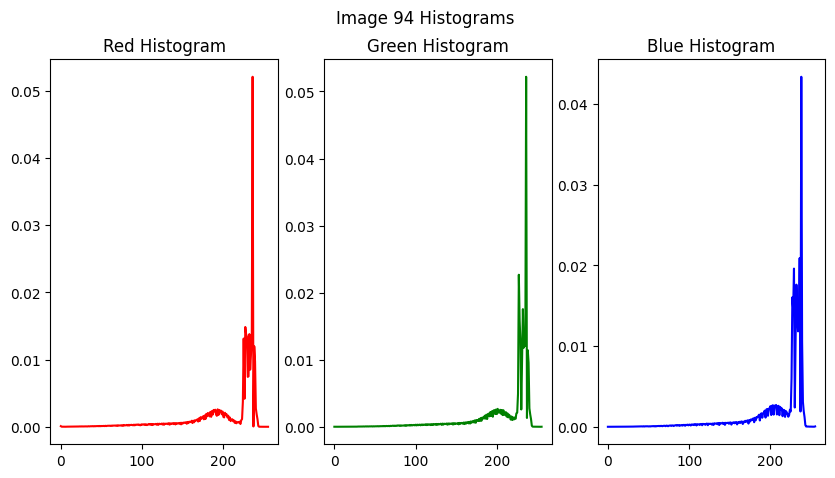

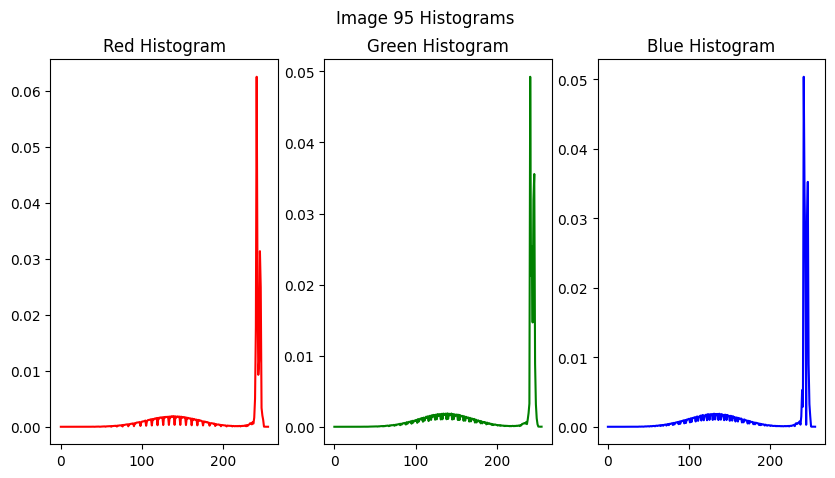

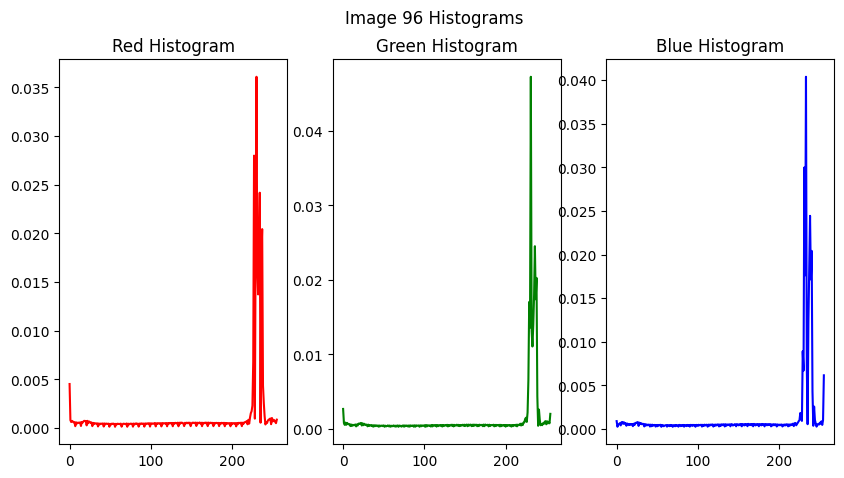

In [19]:
# Sonuçları görselleştirme (isteğe bağlı)
for i, (hist_r, hist_g, hist_b) in enumerate(normalized_histograms):
    plt.figure(figsize=(10, 5))

    plt.subplot(131)
    plt.plot(hist_r, color='red')
    plt.title('Red Histogram')

    plt.subplot(132)
    plt.plot(hist_g, color='green')
    plt.title('Green Histogram')

    plt.subplot(133)
    plt.plot(hist_b, color='blue')
    plt.title('Blue Histogram')

    plt.suptitle(f'Image {i+1} Histograms')
    plt.show()

In [22]:
# K-Means algoritması
class KMeansCustom:
    def __init__(self, k, max_iters=100):
        self.k = k
        self.max_iters = max_iters

    def fit(self, data):
        self.centroids = self._initialize_centroids(data)
        for _ in range(self.max_iters):
            labels = self._assign_labels(data)
            new_centroids = self._update_centroids(data, labels)
            if np.allclose(new_centroids, self.centroids):
                break
            self.centroids = new_centroids

        return labels

    def _initialize_centroids(self, data):
        indices = np.random.choice(len(data), self.k, replace=False)
        centroids = data[indices]
        return centroids

    def _assign_labels(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=-1)
        labels = np.argmin(distances, axis=-1)
        return labels

    def _update_centroids(self, data, labels):
        new_centroids = np.array([np.mean(data[labels == i], axis=0) for i in range(self.k)])
        return new_centroids

# Diğer adımları tekrarlayarak resimleri yükle, histogramları elde et ve normalize et

In [23]:
# K-Means kümeleme işlemi
def k_means_clustering_custom(normalized_histograms, k=5):
    # Histogramları düzleştir
    flattened_histograms = np.array([np.concatenate((hist_r, hist_g, hist_b)) for (hist_r, hist_g, hist_b) in normalized_histograms])
    
    # K-Means modelini oluştur
    kmeans_custom = KMeansCustom(k)
    
    # Kümeleme işlemini gerçekleştir
    clusters = kmeans_custom.fit(flattened_histograms)

    return clusters

In [25]:
# 4. K-Means kümeleme işlemi
k_value = 5
clusters = k_means_clustering_custom(normalized_histograms, k=k_value)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 768 but corresponding boolean dimension is 5

In [ ]:
# # Ana işlem
# def main():
#     images = load_images()
#     histograms = compute_histograms(images)
#     normalized_histograms = normalize_histograms(histograms)

#     # 4. K-Means kümeleme işlemi
#     k_value = 5
#     clusters = k_means_clustering_custom(normalized_histograms, k=k_value)

#     # Sonuçları görselleştirme
#     for i, (hist_r, hist_g, hist_b) in enumerate(normalized_histograms):
#         plt.figure(figsize=(12, 5))

#         plt.subplot(121)
#         plt.plot(hist_r, color='red', label='Red')
#         plt.plot(hist_g, color='green', label='Green')
#         plt.plot(hist_b, color='blue', label='Blue')
#         plt.title(f'Image {i+1} Normalized Histograms')
#         plt.legend()

#         plt.subplot(122)
#         plt.scatter(range(len(hist_r)), np.zeros_like(hist_r), c=clusters, cmap='viridis', s=50)
#         plt.title(f'Image {i+1} K-Means Clustering Result (k={k_value})')

#         plt.show()

In [ ]:
if __name__ == "__main__":
    main()